In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
import warnings
warnings.simplefilter("ignore")

In [11]:
import os

In [12]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [13]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis/notebooks')

In [42]:
from astropy import units
from exomast_api import exoMAST_API
from time import time

import exoplanet as xo
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pymc3 as pm
import starry
import theano.tensor as tt
import theano

starry.config.quiet = True

In [15]:
import joblib
import pandas as pd

from tqdm import tqdm_notebook as tqdm

In [39]:
from arctor import Arctor, info_message
from arctor.utils import instantiate_arctor, create_raw_lc_stddev, instantiate_star_planet_system

In [17]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [277]:
ls /home/nelly/Research/Planets/WASP43/github_analysis/savefiles

deletemetest.joblib.save
raw_light_curve_stddev_test_results_1281_lightcurves.joblib.save
WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_1000ppm_base.joblib.save
WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit.joblib.save
WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_starry_first200.joblib.save
WASP43_savedict_206ppm_100x100_finescale_columnwiseSkyBG.save
WASP43_savedict_206ppm_100x100_finescale.joblib.save
WASP43_savedict_206ppm_100x100.joblib.save
WASP43_savedict_218ppm.joblib.save
WASP43_savedict_backup_221019_206ppm.joblib.save
WASP43_savedict_backup_221019.joblib.save
WASP43_savedict_backup_broken_centers.joblib.save
WASP43_savedict_backup_unknown.joblib.save
WASP43_savedict_before_adding_multiphot_to_object.joblib.save
WASP43_savedict_broken_centering_231019.joblib.save
WASP43_savedict.joblib.save
WASP43_savedict_oneflux.job

In [279]:
planet = instantiate_arctor(planet_name, data_dir, working_dir, file_type)



  0%|          | 0/75 [00:00<?, ?it/s]

 40%|████      | 30/75 [00:00<00:00, 297.38it/s]

[INFO] Initializing Instance of the `Arctor` Object
[INFO] Loading Data from Save File
[INFO] Loading Fits Files




100%|██████████| 75/75 [00:00<00:00, 334.27it/s]


[INFO] Loading Save Object-Dict File
[INFO] Found 75 flt.fits files


In [ ]:
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
joblib_filename = f'{working_dir}/{joblib_filename}'
planet.load_dict(joblib_filename)

In [284]:
planet.photometry_df.columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_23x60', 'aperture_sum_24x60', 'aperture_sum_25x60',
       'aperture_sum_26x60', 'aperture_sum_27x60', 'aperture_sum_28x60',
       'aperture_sum_29x60', 'aperture_sum_30x60', 'xcenter', 'ycenter'],
      dtype='object', length=402)

In [20]:
if not hasattr(planet, 'gaussian_centers'):
    planet.load_dict(joblib_filename)
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [21]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [22]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [23]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [24]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [25]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 16x51 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [26]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

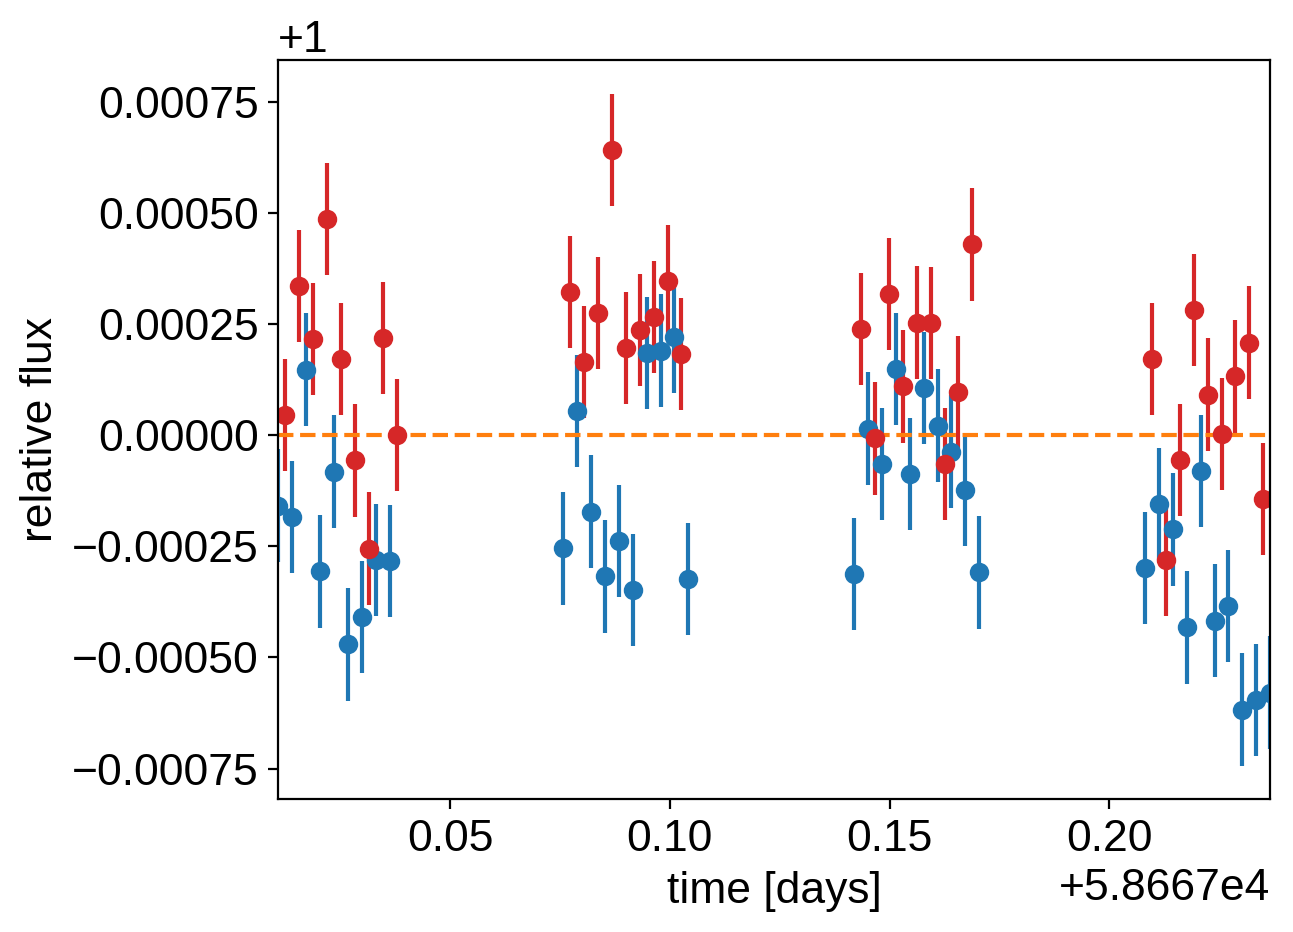

In [27]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df['aperture_sum_16x51']
yerr = planet.normed_uncertainty_df['aperture_sum_16x51']

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="C0")
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="C3")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [28]:
np.random.seed(42)

time_med = np.median(times)
med_t_diff = np.median(np.diff(times))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [29]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [30]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]
t0 = time_med
edepth = np.sqrt(1000/1e6)

orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

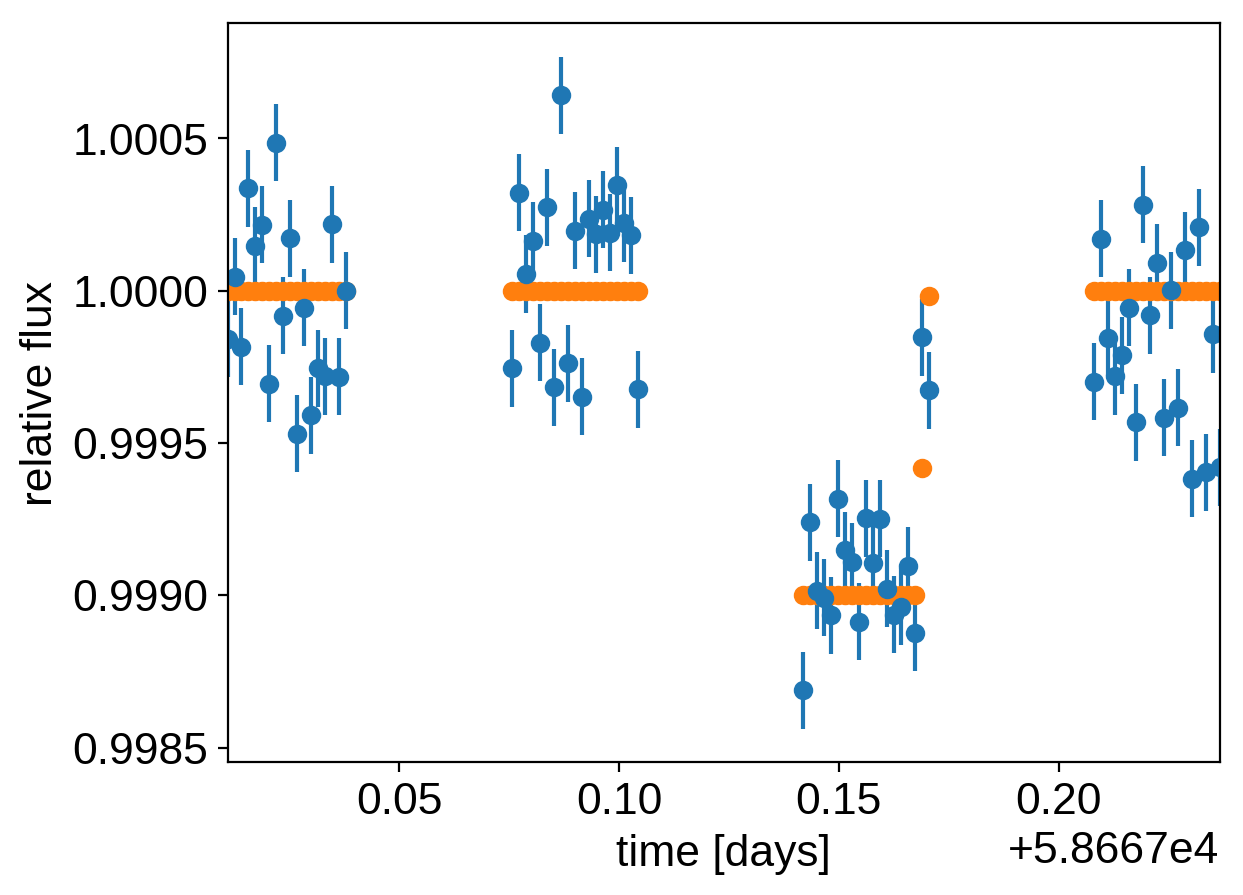

In [31]:
plt.errorbar(times, flux * (injected_light_curves+1), yerr, fmt='o')
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

In [32]:
t0_wasp43 = 55528.3684  # exo.mast.stsci.edu
n_epochs = np.int(np.round(((time_med - t0_wasp43) / period)-0.5))
n_epochs, ((time_med - t0_wasp43) / period)
t0_guess = t0_wasp43 + (n_epochs+0.5) * period

# t0s = np.random.normal(t0_guess, 0.1*med_t_diff, size=2)
t0s = t0_guess

# Run 400 MCMCs

In [34]:
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

edepth = np.sqrt(1000/1e6)
orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curve = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

In [35]:
wasp43_params = exoMAST_API('WASP43b')

In [273]:
kwargs = {}

# Stellar parameters
kwargs['star_ydeg'] = 0
kwargs['star_udeg'] = 2
kwargs['star_L'] = 1.0
kwargs['star_inc'] = 90.0
kwargs['star_obl'] = 0.0
kwargs['star_m'] = wasp43_params.Ms
kwargs['star_r'] = wasp43_params.Rs
kwargs['star_prot'] = 1.0
kwargs['star_t0'] = 0
kwargs['star_theta0'] = 0.0
kwargs['star_A1'] = 1.0
kwargs['star_A2'] = 0.0

# Planetary parameters
kwargs['planet_B1'] = 1.0
kwargs['planet_ydeg'] = 0
kwargs['planet_udeg'] = 0
kwargs['planet_L']  =  5e-4
kwargs['planet_a'] = 1.0
kwargs['planet_phase_offset'] = 0.
kwargs['planet_inc'] = wasp43_params.inclination
kwargs['planet_porb'] = wasp43_params.orbital_period
kwargs['planet_t0'] = 0.0#wasp43_params.transit_time
kwargs['planet_obl'] = 0.0
kwargs['planet_m'] = 0.0  # wasp43_params.Mp
kwargs['planet_r'] = wasp43_params.Rp
kwargs['planet_ecc'] = wasp43_params.eccentricity
kwargs['planet_w'] = wasp43_params.omega
kwargs['planet_Omega'] = 0.0
kwargs['planet_theta0'] = 0.0

sys = instantiate_star_planet_system(**kwargs)
# map_soln, mcmc_trace = run_pymc3(times, flux, yerr, tune=250, draws=500, target_accept=0.9, **kwargs)

In [272]:
# artificial_times = np.linspace(0.49, 0.51, 300)*wasp43_params.orbital_period
artificial_times = np.linspace(times_mod.min(), times_mod.max(), 300)
sys.show(t=artificial_times, window_pad=1, figsize=(5, 5))

In [269]:
n_epochs = np.int(np.round(np.median(((times - wasp43_params.transit_time)/wasp43_params.orbital_period) - 0.5)))
times_mod = times - wasp43_params.transit_time - n_epochs*wasp43_params.orbital_period

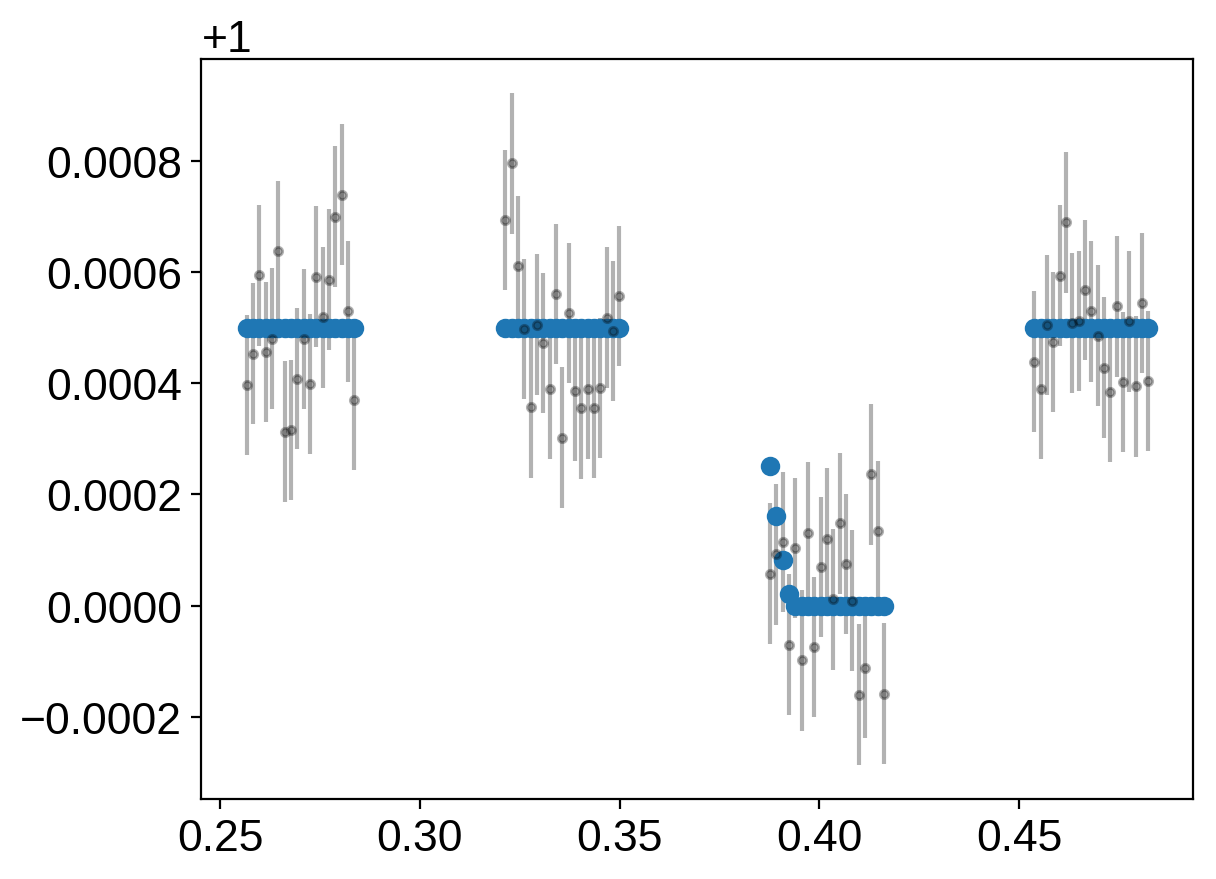

In [274]:
artificial_times = times_mod#np.linspace(-0.01, 1.01, 100)*wasp43_params.orbital_period
flux_true = sys.flux(artificial_times).eval()
ferr = 1e-4
flux = flux_true + yerr * np.random.randn(len(artificial_times))
plt.errorbar(artificial_times, flux, yerr, fmt="ko", alpha=0.3, ms=3, zorder=2)
plt.plot(artificial_times, flux_true, 'o');

In [252]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

# oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

def run_pymc3(times, flux, ferr, xcenters, tune=3000, draws=3000, target_accept=0.9, do_mcmc_now=False, **kwargs):
    """
        KWARGS:
             # Stellar parameters
             star_ydeg=0, star_udeg=2, star_L=1.0, star_inc=90.0, 
             star_obl=0.0, star_m=1.0, star_r=1.0, star_prot=1.0, 
             star_t0=0, star_theta0=0.0, star_A1=0.4, star_A2=0.2, 
             # Planetary parameters
             planet_B1=1.0, planet_ydeg=1, planet_udeg=0, planet_L = 1.0, 
             planet_a=1.0, planet_phase_offset=0., planet_inc=90.0, planet_porb=1.0,
             planet_t0=0.0, planet_obl=0.0, planet_m=0.0, planet_r=0.1, planet_ecc=0.0,
             planet_w=90.0, planet_Omega=0.0, planet_theta0=0.0):
    """
    with pm.Model() as model:
        # planet_phase_offset = pm.Normal("planet_phase_offset", 0.0, 30.0, testval=0.11)
        # log_L = pm.Normal("log_L", -4.0, 2.0, testval=-3.91)
        log_L = pm.Uniform("log_L", -np.inf, 0)
        mean = pm.Normal("mean", mu=0.0, sd=1.0)
            
        # kwargs['planet_phase_offset'] = planet_phase_offset
        kwargs['planet_L'] = 10**log_L
        
        sys = instantiate_star_planet_system(**kwargs)
        light_curve = sys.flux(times)
        
        slope = pm.Uniform("slope", lower=-0.1, upper=0.1)
#         slope_xc = pm.Uniform("slope_xcenter", lower=-0.1, upper=0.1)
        
        line = means + slope * times + slope_xc * xcenters
        
        model_ = light_curve + line
        
        flux_model = pm.Deterministic("flux_model", model_)
        pm.Normal("obs", flux_model, sd=ferr, observed=flux)
        
        start0 = time()
        map_soln = xo.optimize()
        print(f'[INFO] MAP Solution took {time() - start0} seconds')
        
        if do_mcmc_now:
            start1 = time()
            trace = pm.sample(
                tune=tune,
                draws=draws,
                start=map_soln,
                chains=mp.cpu_count(),
                cores=mp.cpu_count(),
                step=xo.get_dense_nuts_step(target_accept=target_accept),
            )
            print(f'[INFO] MCMC took {time() - start1} seconds')
        else:
            trace = None
        print(f'[INFO] Full Process took {time() - start0} seconds')
        
    return map_soln, trace

In [257]:
kwargs['planet_L'] = 

100.0

In [ ]:
sys = instantiate_star_planet_system(**kwargs)

In [254]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']
xcenters_mod = xcenters - np.median(xcenters)

n_epochs = np.int(np.round(np.median(((times - wasp43_params.transit_time)/wasp43_params.orbital_period) - 0.5)))
times_mod = times - wasp43_params.transit_time - n_epochs*wasp43_params.orbital_period


do_mcmc_now = False
save_as_you_go = False

# varnames = ["edepth", "slope_xcenter", "mean", "slope"]
varnames = ['log_L', 'mean', 'slope', 'slope_xcenter']
fine_grain_mcmcs_w_xcenterfit = {}
for colname in aper_sum_columns:  # [fine_min_snr_colname]:  # 
    start = time()
    info_message(f'Working on {colname} for Trace MCMCs')
    flux = fine_snr_flux[colname] * (injected_light_curve + 1.0)
    ferr = fine_snr_uncs[colname]
    
    map_soln, trace  = run_pymc3(times, flux, ferr, xcenters, do_mcmc_now=do_mcmc_now,
                                 tune=3000, draws=3000, target_accept=0.9, **kwargs)
    fine_grain_mcmcs_w_xcenterfit[colname] = {}
    fine_grain_mcmcs_w_xcenterfit[colname]['trace'] = trace
    fine_grain_mcmcs_w_xcenterfit[colname]['map_soln'] = map_soln
    
    if save_as_you_go:
        info_message(f'Completed {colname} for Trace MCMCs took {time()-start}')
        filename = 'WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save'
        filename = os.path.join(working_dir, filename)

        info_message(f'Saving MCMCs to {filename}')
        joblib.dump(fine_grain_mcmcs_w_xcenterfit, filename)
    if trace is not None:
        print(pm.summary(trace, var_names=varnames))

[INFO] Working on aperture_sum_1x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.090610e+05]
1it [00:00, 224.82it/s, logp=-1.090610e+05]
2it [00:00, 277.44it/s, logp=-1.090610e+05]
3it [00:00, 298.07it/s, logp=-5.429272e+15]
4it [00:00, 312.38it/s, logp=-1.064292e+05]
5it [00:00, 315.88it/s, logp=-1.240489e+05]
6it [00:00, 327.26it/s, logp=-1.048087e+05]
7it [00:00, 331.02it/s, logp=-1.285522e+05]
8it [00:00, 334.28it/s, logp=-1.041931e+05]
9it [00:00, 334.65it/s, logp=-1.043236e+05]
10it [00:00, 338.83it/s, logp=-1.039386e+05]
11it [00:00, 335.53it/s, logp=-4.860159e+10]
12it [00:00, 331.14it/s, logp=-1.039386e+05]
13it [00:00, 330.52it/s, logp=-1.039386e+05]
14it [00:00, 330.32it/s, logp=-9.665005e+08]
15it [00:00, 328.90it/s, logp=-1.066784e+05]
16it [00:00, 328.72it/s, logp=-1.039406e+05]
17it [00:00, 325.77it/s, logp=-1.039330e+05]
18it [00:00, 320.80it/s, logp=-1.039216e+05]
19it [00:00, 319.34it/s, logp=-1.038776e+05]
20it [00:00, 309.88it/s, log

[INFO] MAP Solution took 2.928159713745117 seconds
[INFO] Full Process took 2.9281976222991943 seconds
[INFO] Completed aperture_sum_1x1 for Trace MCMCs took 3.7483012676239014
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_6x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089920e+05]
1it [00:00, 221.08it/s, logp=-1.089920e+05]
2it [00:00, 258.92it/s, logp=-1.089920e+05]
3it [00:00, 277.36it/s, logp=-5.437804e+15]
4it [00:00, 288.59it/s, logp=-1.069189e+05]
5it [00:00, 292.21it/s, logp=-1.087261e+05]
6it [00:00, 297.61it/s, logp=-1.051162e+05]
7it [00:00, 298.92it/s, logp=-1.882865e+05]
8it [00:00, 303.53it/s, logp=-1.046970e+05]
9it [00:00, 294.94it/s, logp=-1.043251e+05]
10it [00:00, 289.07it/s, logp=-3.251553e+09]
11it [00:00, 288.54it/s, logp=-1.054267e+05]
12it [00:00, 286.29it/s, logp=-1.042716e+05]
13it [00:00, 280.48it/s, logp=-1.041687e+05]
14it [00:00, 280.24it/s, logp=-1.038688e+05]
15it [00:00, 276.76it/s, logp=-1.033180e+05]
16it [00:00, 278.04it/s, logp=-1.043438e+05]
17it [00:00, 281.74it/s, logp=-1.032016e+05]
18it [00:00, 283.11it/s, logp=-1.030113e+05]
19it [00:00, 285.49it/s, logp=-1.027233e+05]
20it [00:00, 286.39it/s, log

[INFO] MAP Solution took 3.2213025093078613 seconds
[INFO] Full Process took 3.221334934234619 seconds
[INFO] Completed aperture_sum_6x1 for Trace MCMCs took 4.071608781814575
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_11x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089818e+05]
1it [00:00, 147.70it/s, logp=-1.089818e+05]
2it [00:00, 186.02it/s, logp=-1.089818e+05]
3it [00:00, 201.34it/s, logp=-5.438590e+15]
4it [00:00, 213.27it/s, logp=-1.069331e+05]
5it [00:00, 217.22it/s, logp=-1.084830e+05]
6it [00:00, 223.35it/s, logp=-1.051223e+05]
7it [00:00, 225.86it/s, logp=-1.957518e+05]
8it [00:00, 230.08it/s, logp=-1.047228e+05]
9it [00:00, 230.69it/s, logp=-1.042797e+05]
10it [00:00, 232.90it/s, logp=-2.233894e+10]
11it [00:00, 236.69it/s, logp=-1.050338e+05]
12it [00:00, 239.99it/s, logp=-1.042318e+05]
13it [00:00, 240.25it/s, logp=-1.041392e+05]
14it [00:00, 242.82it/s, logp=-1.038670e+05]
15it [00:00, 243.35it/s, logp=-1.033615e+05]
16it [00:00, 242.27it/s, logp=-1.030219e+05]
17it [00:00, 238.58it/s, logp=-1.030767e+05]
18it [00:00, 238.12it/s, logp=-1.028737e+05]
19it [00:00, 237.05it/s, logp=-1.026427e+05]
20it [00:00, 235.38it/s, log

[INFO] MAP Solution took 3.219233989715576 seconds
[INFO] Full Process took 3.219270706176758 seconds
[INFO] Completed aperture_sum_11x1 for Trace MCMCs took 4.113342046737671
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_16x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089805e+05]
1it [00:00, 232.27it/s, logp=-1.089805e+05]
2it [00:00, 269.87it/s, logp=-1.089805e+05]
3it [00:00, 284.64it/s, logp=-5.438874e+15]
4it [00:00, 298.41it/s, logp=-1.069366e+05]
5it [00:00, 299.76it/s, logp=-1.084203e+05]
6it [00:00, 305.95it/s, logp=-1.051219e+05]
7it [00:00, 304.25it/s, logp=-1.985622e+05]
8it [00:00, 305.29it/s, logp=-1.047309e+05]
9it [00:00, 294.47it/s, logp=-1.043248e+05]
10it [00:00, 292.64it/s, logp=-1.974941e+10]
11it [00:00, 287.89it/s, logp=-1.054369e+05]
12it [00:00, 280.60it/s, logp=-1.042803e+05]
13it [00:00, 264.55it/s, logp=-1.041941e+05]
14it [00:00, 257.44it/s, logp=-1.039227e+05]
15it [00:00, 257.72it/s, logp=-1.034221e+05]
16it [00:00, 262.70it/s, logp=-1.030753e+05]
17it [00:00, 267.57it/s, logp=-1.038000e+05]
18it [00:00, 272.21it/s, logp=-1.028825e+05]
19it [00:00, 273.77it/s, logp=-1.030195e+05]
20it [00:00, 277.11it/s, log

[INFO] MAP Solution took 2.836066246032715 seconds
[INFO] Full Process took 2.8361029624938965 seconds
[INFO] Completed aperture_sum_16x1 for Trace MCMCs took 3.7703661918640137
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_21x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089828e+05]
1it [00:00, 183.69it/s, logp=-1.089828e+05]
2it [00:00, 231.19it/s, logp=-1.089828e+05]
3it [00:00, 253.57it/s, logp=-5.439015e+15]
4it [00:00, 266.60it/s, logp=-1.069385e+05]
5it [00:00, 273.97it/s, logp=-1.084282e+05]
6it [00:00, 283.71it/s, logp=-1.051241e+05]
7it [00:00, 288.10it/s, logp=-1.983520e+05]
8it [00:00, 302.33it/s, logp=-1.047326e+05]
9it [00:00, 310.34it/s, logp=-1.043281e+05]
10it [00:00, 319.94it/s, logp=-1.905596e+10]
11it [00:00, 328.93it/s, logp=-1.055411e+05]
12it [00:00, 338.62it/s, logp=-1.042833e+05]
13it [00:00, 341.98it/s, logp=-1.041966e+05]
14it [00:00, 347.58it/s, logp=-1.039236e+05]
15it [00:00, 343.49it/s, logp=-1.034191e+05]
16it [00:00, 341.32it/s, logp=-1.030716e+05]
17it [00:00, 320.26it/s, logp=-1.038843e+05]
18it [00:00, 318.55it/s, logp=-1.028864e+05]
19it [00:00, 313.36it/s, logp=-1.029973e+05]
20it [00:00, 314.35it/s, log

[INFO] MAP Solution took 3.0397984981536865 seconds
[INFO] Full Process took 3.0398359298706055 seconds
[INFO] Completed aperture_sum_21x1 for Trace MCMCs took 3.866201639175415
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_26x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089846e+05]
1it [00:00, 202.81it/s, logp=-1.089846e+05]
2it [00:00, 237.89it/s, logp=-1.089846e+05]
3it [00:00, 255.79it/s, logp=-5.439108e+15]
4it [00:00, 270.73it/s, logp=-1.069406e+05]
5it [00:00, 269.30it/s, logp=-1.084265e+05]
6it [00:00, 272.50it/s, logp=-1.051261e+05]
7it [00:00, 270.86it/s, logp=-1.981446e+05]
8it [00:00, 270.73it/s, logp=-1.047329e+05]
9it [00:00, 266.53it/s, logp=-1.042929e+05]
10it [00:00, 261.80it/s, logp=-2.612675e+10]
11it [00:00, 262.52it/s, logp=-1.045703e+05]
12it [00:00, 257.65it/s, logp=-1.042469e+05]
13it [00:00, 252.77it/s, logp=-1.041579e+05]
14it [00:00, 249.86it/s, logp=-1.038875e+05]
15it [00:00, 247.38it/s, logp=-1.033887e+05]
16it [00:00, 244.95it/s, logp=-1.030503e+05]
17it [00:00, 244.17it/s, logp=-1.041892e+05]
18it [00:00, 243.79it/s, logp=-1.028966e+05]
19it [00:00, 243.12it/s, logp=-1.028915e+05]
20it [00:00, 244.25it/s, log

[INFO] MAP Solution took 2.720656633377075 seconds
[INFO] Full Process took 2.7206902503967285 seconds
[INFO] Completed aperture_sum_26x1 for Trace MCMCs took 3.517981767654419
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_31x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089870e+05]
1it [00:00, 211.52it/s, logp=-1.089870e+05]
2it [00:00, 265.53it/s, logp=-1.089870e+05]
3it [00:00, 276.82it/s, logp=-5.439167e+15]
4it [00:00, 294.44it/s, logp=-1.069421e+05]
5it [00:00, 301.70it/s, logp=-1.084407e+05]
6it [00:00, 305.61it/s, logp=-1.051284e+05]
7it [00:00, 304.16it/s, logp=-1.978928e+05]
8it [00:00, 308.67it/s, logp=-1.047353e+05]
9it [00:00, 308.24it/s, logp=-1.043179e+05]
10it [00:00, 301.13it/s, logp=-2.093229e+10]
11it [00:00, 293.85it/s, logp=-1.052619e+05]
12it [00:00, 293.33it/s, logp=-1.042726e+05]
13it [00:00, 287.76it/s, logp=-1.041847e+05]
14it [00:00, 275.16it/s, logp=-1.039121e+05]
15it [00:00, 268.75it/s, logp=-1.034081e+05]
16it [00:00, 261.22it/s, logp=-1.030636e+05]
17it [00:00, 259.01it/s, logp=-1.040906e+05]
18it [00:00, 261.31it/s, logp=-1.028977e+05]
19it [00:00, 256.17it/s, logp=-1.029353e+05]
20it [00:00, 255.09it/s, log

[INFO] MAP Solution took 2.6575510501861572 seconds
[INFO] Full Process took 2.6575875282287598 seconds
[INFO] Completed aperture_sum_31x1 for Trace MCMCs took 3.504455089569092
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_36x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089920e+05]
1it [00:00, 177.21it/s, logp=-1.089920e+05]
2it [00:00, 195.02it/s, logp=-1.089920e+05]
3it [00:00, 202.82it/s, logp=-5.439200e+15]
4it [00:00, 214.69it/s, logp=-1.069442e+05]
5it [00:00, 213.35it/s, logp=-1.084808e+05]
6it [00:00, 223.03it/s, logp=-1.051326e+05]
7it [00:00, 226.22it/s, logp=-1.967104e+05]
8it [00:00, 234.02it/s, logp=-1.047372e+05]
9it [00:00, 232.32it/s, logp=-1.043447e+05]
10it [00:00, 230.96it/s, logp=-1.420838e+10]
11it [00:00, 230.77it/s, logp=-1.061207e+05]
12it [00:00, 231.32it/s, logp=-1.042986e+05]
13it [00:00, 224.59it/s, logp=-1.042092e+05]
14it [00:00, 225.21it/s, logp=-1.039299e+05]
15it [00:00, 222.20it/s, logp=-1.034107e+05]
16it [00:00, 221.77it/s, logp=-1.030608e+05]
17it [00:00, 221.62it/s, logp=-1.044932e+05]
18it [00:00, 223.31it/s, logp=-1.029143e+05]
19it [00:00, 222.62it/s, logp=-1.028939e+05]
20it [00:00, 223.37it/s, log

[INFO] MAP Solution took 2.9569385051727295 seconds
[INFO] Full Process took 2.9569764137268066 seconds
[INFO] Completed aperture_sum_36x1 for Trace MCMCs took 3.80556321144104
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_41x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089937e+05]
1it [00:00, 198.01it/s, logp=-1.089937e+05]
2it [00:00, 208.23it/s, logp=-1.089937e+05]
3it [00:00, 208.99it/s, logp=-5.439229e+15]
4it [00:00, 218.06it/s, logp=-1.069449e+05]
5it [00:00, 221.70it/s, logp=-1.084961e+05]
6it [00:00, 222.71it/s, logp=-1.051343e+05]
7it [00:00, 222.60it/s, logp=-1.962410e+05]
8it [00:00, 225.56it/s, logp=-1.047379e+05]
9it [00:00, 226.60it/s, logp=-1.043528e+05]
10it [00:00, 224.01it/s, logp=-1.228019e+10]
11it [00:00, 228.46it/s, logp=-1.062281e+05]
12it [00:00, 230.14it/s, logp=-1.043064e+05]
13it [00:00, 225.86it/s, logp=-1.042166e+05]
14it [00:00, 225.26it/s, logp=-1.039364e+05]
15it [00:00, 224.85it/s, logp=-1.034146e+05]
16it [00:00, 224.38it/s, logp=-1.030628e+05]
17it [00:00, 224.03it/s, logp=-1.046521e+05]
18it [00:00, 223.67it/s, logp=-1.029221e+05]
19it [00:00, 223.30it/s, logp=-1.028690e+05]
20it [00:00, 223.49it/s, log

[INFO] MAP Solution took 2.8966448307037354 seconds
[INFO] Full Process took 2.8966875076293945 seconds
[INFO] Completed aperture_sum_41x1 for Trace MCMCs took 3.713533878326416
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_46x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089928e+05]
1it [00:00, 222.72it/s, logp=-1.089928e+05]
2it [00:00, 247.92it/s, logp=-1.089928e+05]
3it [00:00, 264.04it/s, logp=-5.439261e+15]
4it [00:00, 273.83it/s, logp=-1.069449e+05]
5it [00:00, 276.74it/s, logp=-1.084830e+05]
6it [00:00, 280.39it/s, logp=-1.051334e+05]
7it [00:00, 277.14it/s, logp=-1.964544e+05]
8it [00:00, 280.75it/s, logp=-1.047366e+05]
9it [00:00, 281.02it/s, logp=-1.043219e+05]
10it [00:00, 271.47it/s, logp=-1.774510e+10]
11it [00:00, 272.78it/s, logp=-1.057338e+05]
12it [00:00, 274.09it/s, logp=-1.042749e+05]
13it [00:00, 267.99it/s, logp=-1.041839e+05]
14it [00:00, 265.46it/s, logp=-1.039058e+05]
15it [00:00, 258.58it/s, logp=-1.033899e+05]
16it [00:00, 257.23it/s, logp=-1.030424e+05]
17it [00:00, 256.12it/s, logp=-1.061129e+05]
18it [00:00, 257.15it/s, logp=-1.029447e+05]
19it [00:00, 257.18it/s, logp=-1.028011e+05]
20it [00:00, 254.92it/s, log

[INFO] MAP Solution took 2.54317307472229 seconds
[INFO] Full Process took 2.543210029602051 seconds
[INFO] Completed aperture_sum_46x1 for Trace MCMCs took 3.380013942718506
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_51x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089940e+05]
1it [00:00, 216.16it/s, logp=-1.089940e+05]
2it [00:00, 262.66it/s, logp=-1.089940e+05]
3it [00:00, 287.11it/s, logp=-5.439282e+15]
4it [00:00, 302.90it/s, logp=-1.069460e+05]
5it [00:00, 309.42it/s, logp=-1.084850e+05]
6it [00:00, 318.45it/s, logp=-1.051345e+05]
7it [00:00, 320.67it/s, logp=-1.964464e+05]
8it [00:00, 321.42it/s, logp=-1.047377e+05]
9it [00:00, 318.95it/s, logp=-1.043257e+05]
10it [00:00, 319.83it/s, logp=-1.728994e+10]
11it [00:00, 321.37it/s, logp=-1.057961e+05]
12it [00:00, 320.88it/s, logp=-1.042787e+05]
13it [00:00, 317.11it/s, logp=-1.041878e+05]
14it [00:00, 311.34it/s, logp=-1.039099e+05]
15it [00:00, 305.86it/s, logp=-1.033943e+05]
16it [00:00, 301.57it/s, logp=-1.030475e+05]
17it [00:00, 300.05it/s, logp=-1.055487e+05]
18it [00:00, 300.13it/s, logp=-1.029388e+05]
19it [00:00, 299.63it/s, logp=-1.027988e+05]
20it [00:00, 302.36it/s, log

[INFO] MAP Solution took 2.4805490970611572 seconds
[INFO] Full Process took 2.4805848598480225 seconds
[INFO] Completed aperture_sum_51x1 for Trace MCMCs took 3.3068716526031494
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_56x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089918e+05]
1it [00:00, 163.51it/s, logp=-1.089918e+05]
2it [00:00, 189.60it/s, logp=-1.089918e+05]
3it [00:00, 209.12it/s, logp=-5.439313e+15]
4it [00:00, 222.52it/s, logp=-1.069464e+05]
5it [00:00, 231.72it/s, logp=-1.084496e+05]
6it [00:00, 244.99it/s, logp=-1.051328e+05]
7it [00:00, 252.65it/s, logp=-1.978530e+05]
8it [00:00, 263.22it/s, logp=-1.047400e+05]
9it [00:00, 270.70it/s, logp=-1.043354e+05]
10it [00:00, 277.81it/s, logp=-1.816546e+10]
11it [00:00, 284.31it/s, logp=-1.056759e+05]
12it [00:00, 290.76it/s, logp=-1.042901e+05]
13it [00:00, 295.17it/s, logp=-1.042023e+05]
14it [00:00, 299.94it/s, logp=-1.039277e+05]
15it [00:00, 302.89it/s, logp=-1.034196e+05]
16it [00:00, 305.90it/s, logp=-1.030740e+05]
17it [00:00, 308.71it/s, logp=-1.039719e+05]
18it [00:00, 312.18it/s, logp=-1.028977e+05]
19it [00:00, 305.62it/s, logp=-1.029734e+05]
20it [00:00, 298.89it/s, log

[INFO] MAP Solution took 2.957049608230591 seconds
[INFO] Full Process took 2.9570865631103516 seconds
[INFO] Completed aperture_sum_56x1 for Trace MCMCs took 3.877755641937256
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_61x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089932e+05]
1it [00:00, 326.68it/s, logp=-1.089932e+05]
2it [00:00, 407.95it/s, logp=-1.089932e+05]
3it [00:00, 434.34it/s, logp=-5.439333e+15]
4it [00:00, 453.66it/s, logp=-1.069487e+05]
5it [00:00, 458.46it/s, logp=-1.084398e+05]
6it [00:00, 468.82it/s, logp=-1.051342e+05]
7it [00:00, 462.42it/s, logp=-1.986303e+05]
8it [00:00, 470.18it/s, logp=-1.047444e+05]
9it [00:00, 468.96it/s, logp=-1.043724e+05]
10it [00:00, 470.88it/s, logp=-1.349030e+10]
11it [00:00, 475.83it/s, logp=-1.061685e+05]
12it [00:00, 482.33it/s, logp=-1.043288e+05]
13it [00:00, 480.44it/s, logp=-1.042443e+05]
14it [00:00, 484.43it/s, logp=-1.039723e+05]
15it [00:00, 481.55it/s, logp=-1.034673e+05]
16it [00:00, 479.58it/s, logp=-1.030993e+05]
17it [00:00, 479.77it/s, logp=-1.041587e+05]
18it [00:00, 482.89it/s, logp=-1.029145e+05]
19it [00:00, 480.90it/s, logp=-1.030536e+05]
20it [00:00, 483.21it/s, log

[INFO] MAP Solution took 3.09751296043396 seconds
[INFO] Full Process took 3.097545623779297 seconds
[INFO] Completed aperture_sum_61x1 for Trace MCMCs took 3.9313607215881348
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_66x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089911e+05]
1it [00:00, 131.54it/s, logp=-1.089911e+05]
2it [00:00, 162.10it/s, logp=-1.089911e+05]
3it [00:00, 176.59it/s, logp=-5.439349e+15]
4it [00:00, 191.21it/s, logp=-1.069470e+05]
5it [00:00, 191.41it/s, logp=-1.084317e+05]
6it [00:00, 201.85it/s, logp=-1.051322e+05]
7it [00:00, 204.93it/s, logp=-1.981988e+05]
8it [00:00, 203.37it/s, logp=-1.047390e+05]
9it [00:00, 205.20it/s, logp=-1.042977e+05]
10it [00:00, 204.89it/s, logp=-2.655462e+10]
11it [00:00, 207.79it/s, logp=-1.045351e+05]
12it [00:00, 210.61it/s, logp=-1.042516e+05]
13it [00:00, 211.44it/s, logp=-1.041624e+05]
14it [00:00, 215.05it/s, logp=-1.038915e+05]
15it [00:00, 217.31it/s, logp=-1.033922e+05]
16it [00:00, 215.55it/s, logp=-1.030546e+05]
17it [00:00, 213.86it/s, logp=-1.041944e+05]
18it [00:00, 215.06it/s, logp=-1.029018e+05]
19it [00:00, 214.86it/s, logp=-1.028938e+05]
20it [00:00, 215.93it/s, log

[INFO] MAP Solution took 2.8601741790771484 seconds
[INFO] Full Process took 2.8602097034454346 seconds
[INFO] Completed aperture_sum_66x1 for Trace MCMCs took 3.6938488483428955
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_71x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089903e+05]
1it [00:00, 214.50it/s, logp=-1.089903e+05]
2it [00:00, 267.33it/s, logp=-1.089903e+05]
3it [00:00, 288.48it/s, logp=-5.439365e+15]
4it [00:00, 294.68it/s, logp=-1.069467e+05]
5it [00:00, 299.07it/s, logp=-1.084237e+05]
6it [00:00, 307.01it/s, logp=-1.051314e+05]
7it [00:00, 303.66it/s, logp=-1.991085e+05]
8it [00:00, 308.37it/s, logp=-1.047426e+05]
9it [00:00, 306.45it/s, logp=-1.043635e+05]
10it [00:00, 306.04it/s, logp=-1.549643e+10]
11it [00:00, 305.50it/s, logp=-1.060029e+05]
12it [00:00, 305.80it/s, logp=-1.043202e+05]
13it [00:00, 297.50it/s, logp=-1.042361e+05]
14it [00:00, 295.62it/s, logp=-1.039654e+05]
15it [00:00, 288.55it/s, logp=-1.034643e+05]
16it [00:00, 285.04it/s, logp=-1.030969e+05]
17it [00:00, 272.56it/s, logp=-1.041234e+05]
18it [00:00, 272.26it/s, logp=-1.029099e+05]
19it [00:00, 266.68it/s, logp=-1.030600e+05]
20it [00:00, 266.40it/s, log

[INFO] MAP Solution took 3.2408626079559326 seconds
[INFO] Full Process took 3.2409064769744873 seconds
[INFO] Completed aperture_sum_71x1 for Trace MCMCs took 4.302670240402222
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_76x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089939e+05]
1it [00:00, 213.41it/s, logp=-1.089939e+05]
2it [00:00, 261.67it/s, logp=-1.089939e+05]
3it [00:00, 279.97it/s, logp=-5.439360e+15]
4it [00:00, 304.02it/s, logp=-1.069469e+05]
5it [00:00, 313.70it/s, logp=-1.084715e+05]
6it [00:00, 323.44it/s, logp=-1.051344e+05]
7it [00:00, 329.97it/s, logp=-1.969577e+05]
8it [00:00, 337.86it/s, logp=-1.047389e+05]
9it [00:00, 342.91it/s, logp=-1.043245e+05]
10it [00:00, 346.41it/s, logp=-1.860543e+10]
11it [00:00, 351.34it/s, logp=-1.056140e+05]
12it [00:00, 343.02it/s, logp=-1.042781e+05]
13it [00:00, 332.34it/s, logp=-1.041883e+05]
14it [00:00, 328.41it/s, logp=-1.039127e+05]
15it [00:00, 317.71it/s, logp=-1.034021e+05]
16it [00:00, 309.35it/s, logp=-1.030573e+05]
17it [00:00, 305.32it/s, logp=-1.046120e+05]
18it [00:00, 304.61it/s, logp=-1.029200e+05]
19it [00:00, 297.85it/s, logp=-1.028485e+05]
20it [00:00, 294.81it/s, log

[INFO] MAP Solution took 2.718346118927002 seconds
[INFO] Full Process took 2.7183873653411865 seconds
[INFO] Completed aperture_sum_76x1 for Trace MCMCs took 3.766542673110962
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_81x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089931e+05]
1it [00:00, 181.70it/s, logp=-1.089931e+05]
2it [00:00, 230.54it/s, logp=-1.089931e+05]
3it [00:00, 249.40it/s, logp=-5.439372e+15]
4it [00:00, 268.77it/s, logp=-1.069466e+05]
5it [00:00, 273.12it/s, logp=-1.084645e+05]
6it [00:00, 280.61it/s, logp=-1.051339e+05]
7it [00:00, 285.58it/s, logp=-1.977642e+05]
8it [00:00, 281.85it/s, logp=-1.047423e+05]
9it [00:00, 276.87it/s, logp=-1.043879e+05]
10it [00:00, 277.54it/s, logp=-9.732035e+09]
11it [00:00, 282.57it/s, logp=-1.062235e+05]
12it [00:00, 287.39it/s, logp=-1.043445e+05]
13it [00:00, 288.45it/s, logp=-1.042603e+05]
14it [00:00, 289.20it/s, logp=-1.039884e+05]
15it [00:00, 286.37it/s, logp=-1.034790e+05]
16it [00:00, 285.13it/s, logp=-1.030985e+05]
17it [00:00, 282.59it/s, logp=-1.046038e+05]
18it [00:00, 282.80it/s, logp=-1.029307e+05]
19it [00:00, 275.71it/s, logp=-1.029996e+05]
20it [00:00, 273.24it/s, log

[INFO] MAP Solution took 2.9044692516326904 seconds
[INFO] Full Process took 2.904505729675293 seconds
[INFO] Completed aperture_sum_81x1 for Trace MCMCs took 3.923813581466675
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_86x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089932e+05]
1it [00:00, 231.07it/s, logp=-1.089932e+05]
2it [00:00, 271.21it/s, logp=-1.089932e+05]
3it [00:00, 292.67it/s, logp=-5.439390e+15]
4it [00:00, 303.95it/s, logp=-1.069487e+05]
5it [00:00, 307.92it/s, logp=-1.084396e+05]
6it [00:00, 311.47it/s, logp=-1.051343e+05]
7it [00:00, 301.27it/s, logp=-1.985177e+05]
8it [00:00, 297.71it/s, logp=-1.047438e+05]
9it [00:00, 289.25it/s, logp=-1.043590e+05]
10it [00:00, 283.22it/s, logp=-1.556285e+10]
11it [00:00, 281.24it/s, logp=-1.059983e+05]
12it [00:00, 278.21it/s, logp=-1.043149e+05]
13it [00:00, 273.55it/s, logp=-1.042293e+05]
14it [00:00, 270.76it/s, logp=-1.039562e+05]
15it [00:00, 265.72it/s, logp=-1.034507e+05]
16it [00:00, 262.97it/s, logp=-1.030940e+05]
17it [00:00, 261.57it/s, logp=-1.039343e+05]
18it [00:00, 261.79it/s, logp=-1.029022e+05]
19it [00:00, 260.53it/s, logp=-1.030561e+05]
20it [00:00, 260.88it/s, log

[INFO] MAP Solution took 3.0081098079681396 seconds
[INFO] Full Process took 3.008146047592163 seconds
[INFO] Completed aperture_sum_86x1 for Trace MCMCs took 3.829599618911743
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_91x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089934e+05]
1it [00:00, 211.34it/s, logp=-1.089934e+05]
2it [00:00, 265.40it/s, logp=-1.089934e+05]
3it [00:00, 281.88it/s, logp=-5.439401e+15]
4it [00:00, 296.28it/s, logp=-1.069495e+05]
5it [00:00, 301.71it/s, logp=-1.084317e+05]
6it [00:00, 305.30it/s, logp=-1.051345e+05]
7it [00:00, 304.60it/s, logp=-1.985165e+05]
8it [00:00, 307.93it/s, logp=-1.047429e+05]
9it [00:00, 304.44it/s, logp=-1.043236e+05]
10it [00:00, 296.73it/s, logp=-2.237585e+10]
11it [00:00, 296.66it/s, logp=-1.050556e+05]
12it [00:00, 296.17it/s, logp=-1.042789e+05]
13it [00:00, 287.52it/s, logp=-1.041922e+05]
14it [00:00, 283.53it/s, logp=-1.039215e+05]
15it [00:00, 278.20it/s, logp=-1.034218e+05]
16it [00:00, 276.56it/s, logp=-1.030769e+05]
17it [00:00, 273.35it/s, logp=-1.039250e+05]
18it [00:00, 273.70it/s, logp=-1.028969e+05]
19it [00:00, 272.58it/s, logp=-1.029839e+05]
20it [00:00, 273.07it/s, log

[INFO] MAP Solution took 2.550833225250244 seconds
[INFO] Full Process took 2.5508675575256348 seconds
[INFO] Completed aperture_sum_91x1 for Trace MCMCs took 3.4729864597320557
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_96x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089928e+05]
1it [00:00, 216.80it/s, logp=-1.089928e+05]
2it [00:00, 264.47it/s, logp=-1.089928e+05]
3it [00:00, 275.37it/s, logp=-5.439412e+15]
4it [00:00, 282.26it/s, logp=-1.069501e+05]
5it [00:00, 276.20it/s, logp=-1.084160e+05]
6it [00:00, 281.95it/s, logp=-1.051341e+05]
7it [00:00, 282.80it/s, logp=-1.994782e+05]
8it [00:00, 285.59it/s, logp=-1.047460e+05]
9it [00:00, 284.72it/s, logp=-1.043606e+05]
10it [00:00, 283.84it/s, logp=-1.720102e+10]
11it [00:00, 282.90it/s, logp=-1.058096e+05]
12it [00:00, 281.10it/s, logp=-1.043174e+05]
13it [00:00, 276.09it/s, logp=-1.042336e+05]
14it [00:00, 274.68it/s, logp=-1.039640e+05]
15it [00:00, 266.79it/s, logp=-1.034663e+05]
16it [00:00, 264.39it/s, logp=-1.031004e+05]
17it [00:00, 261.02it/s, logp=-1.040890e+05]
18it [00:00, 261.24it/s, logp=-1.029116e+05]
19it [00:00, 256.77it/s, logp=-1.030684e+05]
20it [00:00, 254.40it/s, log

[INFO] MAP Solution took 2.6833105087280273 seconds
[INFO] Full Process took 2.683347463607788 seconds
[INFO] Completed aperture_sum_96x1 for Trace MCMCs took 3.4746851921081543
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_101x1 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.089945e+05]
1it [00:00, 239.63it/s, logp=-1.089945e+05]
2it [00:00, 274.42it/s, logp=-1.089945e+05]
3it [00:00, 292.33it/s, logp=-5.439422e+15]
4it [00:00, 307.19it/s, logp=-1.069527e+05]
5it [00:00, 312.16it/s, logp=-1.084057e+05]
6it [00:00, 320.36it/s, logp=-1.051359e+05]
7it [00:00, 320.23it/s, logp=-1.990430e+05]
8it [00:00, 325.36it/s, logp=-1.047436e+05]
9it [00:00, 326.72it/s, logp=-1.042650e+05]
10it [00:00, 318.49it/s, logp=-3.635900e+10]
11it [00:00, 315.01it/s, logp=-1.042354e+05]
12it [00:00, 302.91it/s, logp=-1.041774e+05]
13it [00:00, 296.22it/s, logp=-1.039857e+05]
14it [00:00, 288.37it/s, logp=-1.036014e+05]
15it [00:00, 283.03it/s, logp=-1.031443e+05]
16it [00:00, 279.08it/s, logp=-1.029689e+05]
17it [00:00, 275.75it/s, logp=-1.026968e+05]
18it [00:00, 272.76it/s, logp=-1.024769e+05]
19it [00:00, 270.33it/s, logp=-1.023939e+05]
20it [00:00, 267.78it/s, log

[INFO] MAP Solution took 2.8763937950134277 seconds
[INFO] Full Process took 2.876431465148926 seconds
[INFO] Completed aperture_sum_101x1 for Trace MCMCs took 3.7752556800842285
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_1x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.525648e+05]
1it [00:00, 276.25it/s, logp=-2.525648e+05]
2it [00:00, 337.09it/s, logp=-2.525648e+05]
3it [00:00, 315.61it/s, logp=-1.503125e+16]
4it [00:00, 293.89it/s, logp=-2.260899e+05]
5it [00:00, 284.67it/s, logp=-1.775606e+07]
6it [00:00, 262.83it/s, logp=-2.164646e+05]
7it [00:00, 250.27it/s, logp=-2.165461e+05]
8it [00:00, 245.60it/s, logp=-2.152447e+05]
9it [00:00, 242.47it/s, logp=-2.168752e+05]
10it [00:00, 238.94it/s, logp=-2.150187e+05]
11it [00:00, 231.65it/s, logp=-2.146013e+05]
12it [00:00, 228.39it/s, logp=-2.138155e+05]
13it [00:00, 224.97it/s, logp=-2.124266e+05]
14it [00:00, 219.71it/s, logp=-2.116651e+05]
15it [00:00, 218.47it/s, logp=-2.118302e+05]
16it [00:00, 213.23it/s, logp=-2.107672e+05]
17it [00:00, 208.74it/s, logp=-2.091141e+05]
18it [00:00, 205.94it/s, logp=-2.068051e+05]
19it [00:00, 204.54it/s, logp=-2.642446e+05]
20it [00:00, 204.21it/s, log

[INFO] MAP Solution took 2.937455415725708 seconds
[INFO] Full Process took 2.937498092651367 seconds
[INFO] Completed aperture_sum_1x6 for Trace MCMCs took 3.783256769180298
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_6x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.539142e+05]
1it [00:00, 195.95it/s, logp=-2.539142e+05]
2it [00:00, 243.48it/s, logp=-2.539142e+05]
3it [00:00, 262.05it/s, logp=-1.505276e+16]
4it [00:00, 274.93it/s, logp=-2.269803e+05]
5it [00:00, 284.19it/s, logp=-2.109951e+07]
6it [00:00, 293.13it/s, logp=-2.178340e+05]
7it [00:00, 300.29it/s, logp=-2.204557e+05]
8it [00:00, 306.24it/s, logp=-2.170507e+05]
9it [00:00, 307.01it/s, logp=-2.186388e+05]
10it [00:00, 310.03it/s, logp=-2.161712e+05]
11it [00:00, 305.46it/s, logp=-2.181737e+05]
12it [00:00, 305.37it/s, logp=-2.162369e+05]
13it [00:00, 303.75it/s, logp=-2.161393e+05]
14it [00:00, 297.87it/s, logp=-2.160759e+05]
15it [00:00, 294.45it/s, logp=-2.158412e+05]
16it [00:00, 283.36it/s, logp=-2.152680e+05]
17it [00:00, 282.58it/s, logp=-2.134454e+05]
18it [00:00, 280.39it/s, logp=-2.113929e+05]
19it [00:00, 276.40it/s, logp=-2.089784e+05]
20it [00:00, 275.42it/s, log

[INFO] MAP Solution took 2.9611270427703857 seconds
[INFO] Full Process took 2.9611642360687256 seconds
[INFO] Completed aperture_sum_6x6 for Trace MCMCs took 3.8641245365142822
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_11x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540911e+05]
1it [00:00, 204.48it/s, logp=-2.540911e+05]
2it [00:00, 207.02it/s, logp=-2.540911e+05]
3it [00:00, 198.47it/s, logp=-1.505553e+16]
4it [00:00, 201.54it/s, logp=-2.269162e+05]
5it [00:00, 191.22it/s, logp=-2.261354e+07]
6it [00:00, 193.81it/s, logp=-2.179684e+05]
7it [00:00, 196.87it/s, logp=-2.207241e+05]
8it [00:00, 198.08it/s, logp=-2.170160e+05]
9it [00:00, 195.10it/s, logp=-2.196270e+05]
10it [00:00, 195.64it/s, logp=-2.161675e+05]
11it [00:00, 193.00it/s, logp=-2.175300e+05]
12it [00:00, 193.97it/s, logp=-2.161952e+05]
13it [00:00, 194.55it/s, logp=-2.161238e+05]
14it [00:00, 191.85it/s, logp=-2.160371e+05]
15it [00:00, 194.11it/s, logp=-2.157223e+05]
16it [00:00, 194.34it/s, logp=-2.149651e+05]
17it [00:00, 195.35it/s, logp=-2.136261e+05]
18it [00:00, 196.07it/s, logp=-2.114879e+05]
19it [00:00, 196.94it/s, logp=-2.101208e+05]
20it [00:00, 198.03it/s, log

[INFO] MAP Solution took 2.8733818531036377 seconds
[INFO] Full Process took 2.8734190464019775 seconds
[INFO] Completed aperture_sum_11x6 for Trace MCMCs took 3.7335715293884277
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_16x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541070e+05]
1it [00:00, 236.90it/s, logp=-2.541070e+05]
2it [00:00, 283.24it/s, logp=-2.541070e+05]
3it [00:00, 305.48it/s, logp=-1.505698e+16]
4it [00:00, 325.52it/s, logp=-2.269427e+05]
5it [00:00, 327.81it/s, logp=-2.257286e+07]
6it [00:00, 339.72it/s, logp=-2.179919e+05]
7it [00:00, 348.61it/s, logp=-2.207442e+05]
8it [00:00, 354.45it/s, logp=-2.170438e+05]
9it [00:00, 356.60it/s, logp=-2.191154e+05]
10it [00:00, 361.02it/s, logp=-2.162171e+05]
11it [00:00, 352.71it/s, logp=-2.179947e+05]
12it [00:00, 353.54it/s, logp=-2.162682e+05]
13it [00:00, 354.11it/s, logp=-2.161835e+05]
14it [00:00, 352.82it/s, logp=-2.161165e+05]
15it [00:00, 353.53it/s, logp=-2.158705e+05]
16it [00:00, 348.19it/s, logp=-2.152703e+05]
17it [00:00, 346.93it/s, logp=-2.133858e+05]
18it [00:00, 343.33it/s, logp=-2.116618e+05]
19it [00:00, 338.84it/s, logp=-2.093852e+05]
20it [00:00, 334.56it/s, log

[INFO] MAP Solution took 2.9715452194213867 seconds
[INFO] Full Process took 2.97158145904541 seconds
[INFO] Completed aperture_sum_16x6 for Trace MCMCs took 3.9049041271209717
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_21x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541106e+05]
1it [00:00, 224.07it/s, logp=-2.541106e+05]
2it [00:00, 279.25it/s, logp=-2.541106e+05]
3it [00:00, 305.58it/s, logp=-1.505784e+16]
4it [00:00, 323.75it/s, logp=-2.269636e+05]
5it [00:00, 333.28it/s, logp=-2.249366e+07]
6it [00:00, 337.95it/s, logp=-2.180050e+05]
7it [00:00, 347.33it/s, logp=-2.207511e+05]
8it [00:00, 355.80it/s, logp=-2.170656e+05]
9it [00:00, 359.02it/s, logp=-2.184250e+05]
10it [00:00, 364.63it/s, logp=-2.162829e+05]
11it [00:00, 362.30it/s, logp=-2.190059e+05]
12it [00:00, 362.14it/s, logp=-2.163650e+05]
13it [00:00, 362.93it/s, logp=-2.162622e+05]
14it [00:00, 357.28it/s, logp=-2.162207e+05]
15it [00:00, 356.23it/s, logp=-2.160659e+05]
16it [00:00, 349.95it/s, logp=-2.156822e+05]
17it [00:00, 349.66it/s, logp=-2.143718e+05]
18it [00:00, 344.27it/s, logp=-2.118541e+05]
19it [00:00, 334.98it/s, logp=-2.095654e+05]
20it [00:00, 328.12it/s, log

[INFO] MAP Solution took 2.655348062515259 seconds
[INFO] Full Process took 2.655385732650757 seconds
[INFO] Completed aperture_sum_21x6 for Trace MCMCs took 3.5307421684265137
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_26x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541173e+05]
1it [00:00, 186.46it/s, logp=-2.541173e+05]
2it [00:00, 222.01it/s, logp=-2.541173e+05]
3it [00:00, 238.10it/s, logp=-1.505838e+16]
4it [00:00, 259.56it/s, logp=-2.269766e+05]
5it [00:00, 267.19it/s, logp=-2.246648e+07]
6it [00:00, 276.76it/s, logp=-2.180156e+05]
7it [00:00, 282.38it/s, logp=-2.207594e+05]
8it [00:00, 291.82it/s, logp=-2.170791e+05]
9it [00:00, 296.83it/s, logp=-2.190919e+05]
10it [00:00, 303.51it/s, logp=-2.162503e+05]
11it [00:00, 309.40it/s, logp=-2.180318e+05]
12it [00:00, 314.68it/s, logp=-2.163020e+05]
13it [00:00, 317.39it/s, logp=-2.162167e+05]
14it [00:00, 322.17it/s, logp=-2.161499e+05]
15it [00:00, 327.53it/s, logp=-2.159044e+05]
16it [00:00, 331.64it/s, logp=-2.153061e+05]
17it [00:00, 333.04it/s, logp=-2.142165e+05]
18it [00:00, 335.22it/s, logp=-2.123999e+05]
19it [00:00, 335.78it/s, logp=-2.108622e+05]
20it [00:00, 336.59it/s, log

[INFO] MAP Solution took 2.8726649284362793 seconds
[INFO] Full Process took 2.8726987838745117 seconds
[INFO] Completed aperture_sum_26x6 for Trace MCMCs took 3.7084460258483887
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_31x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541143e+05]
1it [00:00, 125.69it/s, logp=-2.541143e+05]
2it [00:00, 163.77it/s, logp=-2.541143e+05]
3it [00:00, 177.56it/s, logp=-1.505878e+16]
4it [00:00, 173.48it/s, logp=-2.269894e+05]
5it [00:00, 171.46it/s, logp=-2.238845e+07]
6it [00:00, 177.52it/s, logp=-2.180200e+05]
7it [00:00, 183.34it/s, logp=-2.207576e+05]
8it [00:00, 190.62it/s, logp=-2.170921e+05]
9it [00:00, 189.06it/s, logp=-2.186905e+05]
10it [00:00, 192.96it/s, logp=-2.162846e+05]
11it [00:00, 191.16it/s, logp=-2.185124e+05]
12it [00:00, 195.62it/s, logp=-2.163538e+05]
13it [00:00, 197.06it/s, logp=-2.162582e+05]
14it [00:00, 197.81it/s, logp=-2.162057e+05]
15it [00:00, 201.01it/s, logp=-2.160111e+05]
16it [00:00, 200.95it/s, logp=-2.155319e+05]
17it [00:00, 201.95it/s, logp=-2.139537e+05]
18it [00:00, 200.45it/s, logp=-2.116165e+05]
19it [00:00, 200.41it/s, logp=-2.092151e+05]
20it [00:00, 200.18it/s, log

[INFO] MAP Solution took 2.942505121231079 seconds
[INFO] Full Process took 2.9425437450408936 seconds
[INFO] Completed aperture_sum_31x6 for Trace MCMCs took 3.7301888465881348
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_36x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541127e+05]
1it [00:00, 252.47it/s, logp=-2.541127e+05]
2it [00:00, 300.34it/s, logp=-2.541127e+05]
3it [00:00, 304.67it/s, logp=-1.505907e+16]
4it [00:00, 322.45it/s, logp=-2.270020e+05]
5it [00:00, 323.72it/s, logp=-2.231117e+07]
6it [00:00, 328.52it/s, logp=-2.180236e+05]
7it [00:00, 328.83it/s, logp=-2.207550e+05]
8it [00:00, 332.92it/s, logp=-2.171043e+05]
9it [00:00, 322.62it/s, logp=-2.188750e+05]
10it [00:00, 323.10it/s, logp=-2.162810e+05]
11it [00:00, 316.27it/s, logp=-2.182818e+05]
12it [00:00, 314.26it/s, logp=-2.163425e+05]
13it [00:00, 312.77it/s, logp=-2.162511e+05]
14it [00:00, 306.51it/s, logp=-2.161916e+05]
15it [00:00, 297.34it/s, logp=-2.159718e+05]
16it [00:00, 288.35it/s, logp=-2.154329e+05]
17it [00:00, 283.18it/s, logp=-2.136954e+05]
18it [00:00, 277.55it/s, logp=-2.113998e+05]
19it [00:00, 272.03it/s, logp=-2.090367e+05]
20it [00:00, 267.50it/s, log

[INFO] MAP Solution took 2.898003578186035 seconds
[INFO] Full Process took 2.8980460166931152 seconds
[INFO] Completed aperture_sum_36x6 for Trace MCMCs took 3.751206636428833
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_41x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540984e+05]
1it [00:00, 369.02it/s, logp=-2.540984e+05]
2it [00:00, 466.27it/s, logp=-2.540984e+05]
3it [00:00, 477.73it/s, logp=-1.505931e+16]
4it [00:00, 489.75it/s, logp=-2.270095e+05]
5it [00:00, 488.89it/s, logp=-2.220488e+07]
6it [00:00, 494.96it/s, logp=-2.180199e+05]
7it [00:00, 498.58it/s, logp=-2.207424e+05]
8it [00:00, 504.03it/s, logp=-2.171122e+05]
9it [00:00, 500.71it/s, logp=-2.204695e+05]
10it [00:00, 503.42it/s, logp=-2.162250e+05]
11it [00:00, 501.85it/s, logp=-2.171727e+05]
12it [00:00, 504.07it/s, logp=-2.162189e+05]
13it [00:00, 499.11it/s, logp=-2.162066e+05]
14it [00:00, 501.79it/s, logp=-2.161579e+05]
15it [00:00, 503.50it/s, logp=-2.159726e+05]
16it [00:00, 505.32it/s, logp=-2.153802e+05]
17it [00:00, 502.70it/s, logp=-2.139203e+05]
18it [00:00, 500.97it/s, logp=-2.117603e+05]
19it [00:00, 499.19it/s, logp=-2.093334e+05]
20it [00:00, 497.58it/s, log

[INFO] MAP Solution took 3.054044485092163 seconds
[INFO] Full Process took 3.0540823936462402 seconds
[INFO] Completed aperture_sum_41x6 for Trace MCMCs took 3.8422582149505615
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_46x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.541051e+05]
1it [00:00, 203.07it/s, logp=-2.541051e+05]
2it [00:00, 246.43it/s, logp=-2.541051e+05]
3it [00:00, 235.60it/s, logp=-1.505946e+16]
4it [00:00, 237.26it/s, logp=-2.270119e+05]
5it [00:00, 237.71it/s, logp=-2.222754e+07]
6it [00:00, 240.71it/s, logp=-2.180248e+05]
7it [00:00, 244.70it/s, logp=-2.207493e+05]
8it [00:00, 248.93it/s, logp=-2.171147e+05]
9it [00:00, 247.97it/s, logp=-2.201145e+05]
10it [00:00, 251.00it/s, logp=-2.162377e+05]
11it [00:00, 248.26it/s, logp=-2.173680e+05]
12it [00:00, 249.68it/s, logp=-2.162481e+05]
13it [00:00, 246.43it/s, logp=-2.161855e+05]
14it [00:00, 242.52it/s, logp=-2.160819e+05]
15it [00:00, 241.07it/s, logp=-2.157091e+05]
16it [00:00, 238.98it/s, logp=-2.148222e+05]
17it [00:00, 237.49it/s, logp=-2.132905e+05]
18it [00:00, 233.91it/s, logp=-2.109281e+05]
19it [00:00, 232.95it/s, logp=-2.089004e+05]
20it [00:00, 232.09it/s, log

[INFO] MAP Solution took 3.272599458694458 seconds
[INFO] Full Process took 3.272636651992798 seconds
[INFO] Completed aperture_sum_46x6 for Trace MCMCs took 4.0758771896362305
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_51x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540962e+05]
1it [00:00, 237.84it/s, logp=-2.540962e+05]
2it [00:00, 279.99it/s, logp=-2.540962e+05]
3it [00:00, 290.46it/s, logp=-1.505962e+16]
4it [00:00, 300.95it/s, logp=-2.270219e+05]
5it [00:00, 300.87it/s, logp=-2.213663e+07]
6it [00:00, 304.93it/s, logp=-2.180253e+05]
7it [00:00, 309.25it/s, logp=-2.207421e+05]
8it [00:00, 312.86it/s, logp=-2.171251e+05]
9it [00:00, 310.68it/s, logp=-2.189702e+05]
10it [00:00, 309.00it/s, logp=-2.162894e+05]
11it [00:00, 303.36it/s, logp=-2.182211e+05]
12it [00:00, 300.84it/s, logp=-2.163484e+05]
13it [00:00, 299.52it/s, logp=-2.162579e+05]
14it [00:00, 289.79it/s, logp=-2.161953e+05]
15it [00:00, 273.04it/s, logp=-2.159642e+05]
16it [00:00, 261.14it/s, logp=-2.153992e+05]
17it [00:00, 262.57it/s, logp=-2.135944e+05]
18it [00:00, 260.11it/s, logp=-2.111709e+05]
19it [00:00, 256.64it/s, logp=-2.092350e+05]
20it [00:00, 254.11it/s, log

[INFO] MAP Solution took 3.0749595165252686 seconds
[INFO] Full Process took 3.074991226196289 seconds
[INFO] Completed aperture_sum_51x6 for Trace MCMCs took 3.8753771781921387
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_56x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540763e+05]
1it [00:00, 198.27it/s, logp=-2.540763e+05]
2it [00:00, 231.51it/s, logp=-2.540763e+05]
3it [00:00, 239.85it/s, logp=-1.505977e+16]
4it [00:00, 251.63it/s, logp=-2.270214e+05]
5it [00:00, 262.96it/s, logp=-2.204423e+07]
6it [00:00, 273.05it/s, logp=-2.180154e+05]
7it [00:00, 281.27it/s, logp=-2.207242e+05]
8it [00:00, 291.35it/s, logp=-2.171252e+05]
9it [00:00, 297.62it/s, logp=-2.202528e+05]
10it [00:00, 302.31it/s, logp=-2.162371e+05]
11it [00:00, 304.93it/s, logp=-2.172668e+05]
12it [00:00, 310.68it/s, logp=-2.162389e+05]
13it [00:00, 314.59it/s, logp=-2.161807e+05]
14it [00:00, 317.32it/s, logp=-2.160689e+05]
15it [00:00, 321.06it/s, logp=-2.156680e+05]
16it [00:00, 322.07it/s, logp=-2.147204e+05]
17it [00:00, 322.97it/s, logp=-2.131034e+05]
18it [00:00, 324.78it/s, logp=-2.106438e+05]
19it [00:00, 326.79it/s, logp=-2.090709e+05]
20it [00:00, 328.19it/s, log

[INFO] MAP Solution took 2.9161856174468994 seconds
[INFO] Full Process took 2.9162235260009766 seconds
[INFO] Completed aperture_sum_56x6 for Trace MCMCs took 3.7606618404388428
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_61x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540514e+05]
1it [00:00, 210.53it/s, logp=-2.540514e+05]
2it [00:00, 265.66it/s, logp=-2.540514e+05]
3it [00:00, 286.70it/s, logp=-1.505992e+16]
4it [00:00, 302.05it/s, logp=-2.270286e+05]
5it [00:00, 305.57it/s, logp=-2.188991e+07]
6it [00:00, 310.46it/s, logp=-2.180064e+05]
7it [00:00, 316.44it/s, logp=-2.207016e+05]
8it [00:00, 319.82it/s, logp=-2.171329e+05]
9it [00:00, 320.62it/s, logp=-2.198516e+05]
10it [00:00, 323.34it/s, logp=-2.162501e+05]
11it [00:00, 313.59it/s, logp=-2.174652e+05]
12it [00:00, 313.60it/s, logp=-2.162678e+05]
13it [00:00, 313.25it/s, logp=-2.162005e+05]
14it [00:00, 306.62it/s, logp=-2.161023e+05]
15it [00:00, 307.18it/s, logp=-2.157470e+05]
16it [00:00, 301.81it/s, logp=-2.149001e+05]
17it [00:00, 300.02it/s, logp=-2.134281e+05]
18it [00:00, 295.38it/s, logp=-2.111324e+05]
19it [00:00, 288.61it/s, logp=-2.100502e+05]
20it [00:00, 285.36it/s, log

[INFO] MAP Solution took 2.839003324508667 seconds
[INFO] Full Process took 2.8390395641326904 seconds
[INFO] Completed aperture_sum_61x6 for Trace MCMCs took 3.637099027633667
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_66x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540634e+05]
1it [00:00, 189.93it/s, logp=-2.540634e+05]
2it [00:00, 227.93it/s, logp=-2.540634e+05]
3it [00:00, 245.81it/s, logp=-1.505997e+16]
4it [00:00, 261.97it/s, logp=-2.270223e+05]
5it [00:00, 269.98it/s, logp=-2.198194e+07]
6it [00:00, 279.12it/s, logp=-2.180103e+05]
7it [00:00, 287.86it/s, logp=-2.207136e+05]
8it [00:00, 293.62it/s, logp=-2.171268e+05]
9it [00:00, 295.53it/s, logp=-2.190184e+05]
10it [00:00, 301.29it/s, logp=-2.162810e+05]
11it [00:00, 304.73it/s, logp=-2.181120e+05]
12it [00:00, 309.31it/s, logp=-2.163361e+05]
13it [00:00, 312.35it/s, logp=-2.162476e+05]
14it [00:00, 312.86it/s, logp=-2.161811e+05]
15it [00:00, 315.12it/s, logp=-2.159364e+05]
16it [00:00, 315.02it/s, logp=-2.153393e+05]
17it [00:00, 317.90it/s, logp=-2.134557e+05]
18it [00:00, 319.33it/s, logp=-2.112903e+05]
19it [00:00, 320.56it/s, logp=-2.089110e+05]
20it [00:00, 322.31it/s, log

[INFO] MAP Solution took 2.7975003719329834 seconds
[INFO] Full Process took 2.7975375652313232 seconds
[INFO] Completed aperture_sum_66x6 for Trace MCMCs took 3.597510576248169
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_71x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540638e+05]
1it [00:00, 228.46it/s, logp=-2.540638e+05]
2it [00:00, 271.73it/s, logp=-2.540638e+05]
3it [00:00, 286.03it/s, logp=-1.506003e+16]
4it [00:00, 307.88it/s, logp=-2.270198e+05]
5it [00:00, 315.43it/s, logp=-2.199490e+07]
6it [00:00, 327.71it/s, logp=-2.180089e+05]
7it [00:00, 332.96it/s, logp=-2.207134e+05]
8it [00:00, 337.45it/s, logp=-2.171240e+05]
9it [00:00, 329.64it/s, logp=-2.190614e+05]
10it [00:00, 324.35it/s, logp=-2.162761e+05]
11it [00:00, 314.25it/s, logp=-2.180641e+05]
12it [00:00, 311.95it/s, logp=-2.163293e+05]
13it [00:00, 311.25it/s, logp=-2.162419e+05]
14it [00:00, 304.02it/s, logp=-2.161738e+05]
15it [00:00, 297.74it/s, logp=-2.159234e+05]
16it [00:00, 290.24it/s, logp=-2.153137e+05]
17it [00:00, 283.84it/s, logp=-2.142056e+05]
18it [00:00, 279.50it/s, logp=-2.123642e+05]
19it [00:00, 277.38it/s, logp=-2.106113e+05]
20it [00:00, 276.64it/s, log

[INFO] MAP Solution took 2.658982276916504 seconds
[INFO] Full Process took 2.6590230464935303 seconds
[INFO] Completed aperture_sum_71x6 for Trace MCMCs took 3.4606778621673584
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_76x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540602e+05]
1it [00:00, 140.21it/s, logp=-2.540602e+05]
2it [00:00, 178.59it/s, logp=-2.540602e+05]
3it [00:00, 191.75it/s, logp=-1.506011e+16]
4it [00:00, 206.10it/s, logp=-2.270231e+05]
5it [00:00, 207.93it/s, logp=-2.195943e+07]
6it [00:00, 216.34it/s, logp=-2.180084e+05]
7it [00:00, 222.17it/s, logp=-2.207098e+05]
8it [00:00, 228.33it/s, logp=-2.171274e+05]
9it [00:00, 230.93it/s, logp=-2.192346e+05]
10it [00:00, 233.43it/s, logp=-2.162696e+05]
11it [00:00, 226.77it/s, logp=-2.179068e+05]
12it [00:00, 229.35it/s, logp=-2.163150e+05]
13it [00:00, 231.58it/s, logp=-2.162321e+05]
14it [00:00, 229.58it/s, logp=-2.161574e+05]
15it [00:00, 231.87it/s, logp=-2.158837e+05]
16it [00:00, 232.75it/s, logp=-2.152196e+05]
17it [00:00, 231.18it/s, logp=-2.140236e+05]
18it [00:00, 231.46it/s, logp=-2.120754e+05]
19it [00:00, 230.39it/s, logp=-2.095930e+05]
20it [00:00, 231.15it/s, log

[INFO] MAP Solution took 3.258742094039917 seconds
[INFO] Full Process took 3.2588179111480713 seconds
[INFO] Completed aperture_sum_76x6 for Trace MCMCs took 4.085672378540039
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_81x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540532e+05]
1it [00:00, 235.99it/s, logp=-2.540532e+05]
2it [00:00, 287.51it/s, logp=-2.540532e+05]
3it [00:00, 303.74it/s, logp=-1.506018e+16]
4it [00:00, 316.62it/s, logp=-2.270230e+05]
5it [00:00, 319.92it/s, logp=-2.192715e+07]
6it [00:00, 327.39it/s, logp=-2.180050e+05]
7it [00:00, 332.05it/s, logp=-2.207035e+05]
8it [00:00, 337.82it/s, logp=-2.171275e+05]
9it [00:00, 334.56it/s, logp=-2.191433e+05]
10it [00:00, 336.50it/s, logp=-2.162719e+05]
11it [00:00, 333.36it/s, logp=-2.179738e+05]
12it [00:00, 335.28it/s, logp=-2.163209e+05]
13it [00:00, 337.09it/s, logp=-2.162358e+05]
14it [00:00, 335.19it/s, logp=-2.161639e+05]
15it [00:00, 333.90it/s, logp=-2.159000e+05]
16it [00:00, 325.37it/s, logp=-2.152585e+05]
17it [00:00, 308.98it/s, logp=-2.140984e+05]
18it [00:00, 300.84it/s, logp=-2.121984e+05]
19it [00:00, 295.23it/s, logp=-2.096712e+05]
20it [00:00, 288.40it/s, log

[INFO] MAP Solution took 2.7647695541381836 seconds
[INFO] Full Process took 2.7648065090179443 seconds
[INFO] Completed aperture_sum_81x6 for Trace MCMCs took 3.6069016456604004
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_86x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540641e+05]
1it [00:00, 158.72it/s, logp=-2.540641e+05]
2it [00:00, 183.94it/s, logp=-2.540641e+05]
3it [00:00, 193.80it/s, logp=-1.506025e+16]
4it [00:00, 206.67it/s, logp=-2.270424e+05]
5it [00:00, 213.50it/s, logp=-2.188791e+07]
6it [00:00, 219.33it/s, logp=-2.180204e+05]
7it [00:00, 225.66it/s, logp=-2.207154e+05]
8it [00:00, 231.72it/s, logp=-2.171471e+05]
9it [00:00, 230.90it/s, logp=-2.189475e+05]
10it [00:00, 234.29it/s, logp=-2.163017e+05]
11it [00:00, 231.90it/s, logp=-2.182238e+05]
12it [00:00, 229.98it/s, logp=-2.163612e+05]
13it [00:00, 229.91it/s, logp=-2.162698e+05]
14it [00:00, 224.45it/s, logp=-2.162063e+05]
15it [00:00, 225.51it/s, logp=-2.159719e+05]
16it [00:00, 220.94it/s, logp=-2.153994e+05]
17it [00:00, 224.00it/s, logp=-2.135889e+05]
18it [00:00, 222.93it/s, logp=-2.119865e+05]
19it [00:00, 220.52it/s, logp=-2.098007e+05]
20it [00:00, 219.32it/s, log

[INFO] MAP Solution took 2.981217861175537 seconds
[INFO] Full Process took 2.9812557697296143 seconds
[INFO] Completed aperture_sum_86x6 for Trace MCMCs took 3.776853084564209
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_91x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540757e+05]
1it [00:00, 231.37it/s, logp=-2.540757e+05]
2it [00:00, 268.32it/s, logp=-2.540757e+05]
3it [00:00, 280.52it/s, logp=-1.506026e+16]
4it [00:00, 293.91it/s, logp=-2.270403e+05]
5it [00:00, 300.98it/s, logp=-2.195757e+07]
6it [00:00, 311.46it/s, logp=-2.180261e+05]
7it [00:00, 316.53it/s, logp=-2.207272e+05]
8it [00:00, 322.51it/s, logp=-2.171452e+05]
9it [00:00, 322.03it/s, logp=-2.185505e+05]
10it [00:00, 325.16it/s, logp=-2.163288e+05]
11it [00:00, 324.40it/s, logp=-2.187919e+05]
12it [00:00, 324.23it/s, logp=-2.164069e+05]
13it [00:00, 322.69it/s, logp=-2.163047e+05]
14it [00:00, 319.32it/s, logp=-2.162567e+05]
15it [00:00, 310.65it/s, logp=-2.160779e+05]
16it [00:00, 295.70it/s, logp=-2.156367e+05]
17it [00:00, 285.49it/s, logp=-2.141685e+05]
18it [00:00, 280.87it/s, logp=-2.119471e+05]
19it [00:00, 277.56it/s, logp=-2.095043e+05]
20it [00:00, 275.11it/s, log

[INFO] MAP Solution took 2.4424986839294434 seconds
[INFO] Full Process took 2.442538022994995 seconds
[INFO] Completed aperture_sum_91x6 for Trace MCMCs took 3.254744291305542
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_96x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540739e+05]
1it [00:00, 180.67it/s, logp=-2.540739e+05]
2it [00:00, 235.64it/s, logp=-2.540739e+05]
3it [00:00, 262.41it/s, logp=-1.506030e+16]
4it [00:00, 281.30it/s, logp=-2.270371e+05]
5it [00:00, 288.32it/s, logp=-2.196546e+07]
6it [00:00, 296.30it/s, logp=-2.180238e+05]
7it [00:00, 301.52it/s, logp=-2.207257e+05]
8it [00:00, 305.62it/s, logp=-2.171421e+05]
9it [00:00, 304.99it/s, logp=-2.195314e+05]
10it [00:00, 306.58it/s, logp=-2.162736e+05]
11it [00:00, 289.41it/s, logp=-2.176991e+05]
12it [00:00, 283.86it/s, logp=-2.163066e+05]
13it [00:00, 277.66it/s, logp=-2.162308e+05]
14it [00:00, 264.38it/s, logp=-2.161459e+05]
15it [00:00, 256.04it/s, logp=-2.158365e+05]
16it [00:00, 252.53it/s, logp=-2.150914e+05]
17it [00:00, 249.53it/s, logp=-2.137705e+05]
18it [00:00, 240.88it/s, logp=-2.116561e+05]
19it [00:00, 236.51it/s, logp=-2.097690e+05]
20it [00:00, 232.50it/s, log

[INFO] MAP Solution took 3.0290753841400146 seconds
[INFO] Full Process took 3.0291144847869873 seconds
[INFO] Completed aperture_sum_96x6 for Trace MCMCs took 3.8402559757232666
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_101x6 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.540698e+05]
1it [00:00, 221.58it/s, logp=-2.540698e+05]
2it [00:00, 271.48it/s, logp=-2.540698e+05]
3it [00:00, 288.34it/s, logp=-1.506034e+16]
4it [00:00, 307.75it/s, logp=-2.270408e+05]
5it [00:00, 309.27it/s, logp=-2.193039e+07]
6it [00:00, 315.20it/s, logp=-2.180242e+05]
7it [00:00, 301.18it/s, logp=-2.207229e+05]
8it [00:00, 296.76it/s, logp=-2.171462e+05]
9it [00:00, 283.45it/s, logp=-2.197867e+05]
10it [00:00, 281.22it/s, logp=-2.162672e+05]
11it [00:00, 275.66it/s, logp=-2.175395e+05]
12it [00:00, 274.37it/s, logp=-2.162893e+05]
13it [00:00, 272.98it/s, logp=-2.162196e+05]
14it [00:00, 266.59it/s, logp=-2.161252e+05]
15it [00:00, 264.48it/s, logp=-2.157832e+05]
16it [00:00, 258.85it/s, logp=-2.149645e+05]
17it [00:00, 255.83it/s, logp=-2.135316e+05]
18it [00:00, 252.89it/s, logp=-2.112916e+05]
19it [00:00, 250.56it/s, logp=-2.090115e+05]
20it [00:00, 248.93it/s, log

[INFO] MAP Solution took 2.9849040508270264 seconds
[INFO] Full Process took 2.9849584102630615 seconds
[INFO] Completed aperture_sum_101x6 for Trace MCMCs took 3.8524575233459473
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_1x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.761951e+05]
1it [00:00, 214.72it/s, logp=-2.761951e+05]
2it [00:00, 269.00it/s, logp=-2.761951e+05]
3it [00:00, 290.25it/s, logp=-1.621525e+16]
4it [00:00, 307.11it/s, logp=-2.378406e+05]
5it [00:00, 308.93it/s, logp=-8.412720e+07]
6it [00:00, 318.83it/s, logp=-2.363021e+05]
7it [00:00, 324.21it/s, logp=-2.345979e+05]
8it [00:00, 324.52it/s, logp=-2.262150e+05]
9it [00:00, 316.97it/s, logp=-2.587884e+05]
10it [00:00, 311.36it/s, logp=-2.255198e+05]
11it [00:00, 294.70it/s, logp=-2.264533e+05]
12it [00:00, 292.38it/s, logp=-2.254970e+05]
13it [00:00, 285.96it/s, logp=-2.254513e+05]
14it [00:00, 283.58it/s, logp=-2.252793e+05]
15it [00:00, 272.51it/s, logp=-2.248538e+05]
16it [00:00, 270.95it/s, logp=-2.234090e+05]
17it [00:00, 268.99it/s, logp=-2.205492e+05]
18it [00:00, 266.32it/s, logp=-2.183095e+05]
19it [00:00, 259.43it/s, logp=-2.157597e+05]
20it [00:00, 257.10it/s, log

[INFO] MAP Solution took 3.1792256832122803 seconds
[INFO] Full Process took 3.1792635917663574 seconds
[INFO] Completed aperture_sum_1x11 for Trace MCMCs took 4.039343595504761
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_6x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.764660e+05]
1it [00:00, 228.12it/s, logp=-2.764660e+05]
2it [00:00, 283.53it/s, logp=-2.764660e+05]
3it [00:00, 290.17it/s, logp=-1.624273e+16]
4it [00:00, 297.74it/s, logp=-2.387945e+05]
5it [00:00, 299.63it/s, logp=-8.078226e+07]
6it [00:00, 305.47it/s, logp=-2.369040e+05]
7it [00:00, 310.50it/s, logp=-2.355364e+05]
8it [00:00, 314.67it/s, logp=-2.273388e+05]
9it [00:00, 311.22it/s, logp=-2.620730e+05]
10it [00:00, 306.15it/s, logp=-2.266273e+05]
11it [00:00, 300.54it/s, logp=-2.273726e+05]
12it [00:00, 300.13it/s, logp=-2.265874e+05]
13it [00:00, 293.85it/s, logp=-2.265081e+05]
14it [00:00, 291.89it/s, logp=-2.262211e+05]
15it [00:00, 283.95it/s, logp=-2.255191e+05]
16it [00:00, 282.30it/s, logp=-2.242403e+05]
17it [00:00, 276.52it/s, logp=-2.221224e+05]
18it [00:00, 272.62it/s, logp=-2.190502e+05]
19it [00:00, 270.30it/s, logp=-2.244593e+05]
20it [00:00, 271.63it/s, log

[INFO] MAP Solution took 2.861231803894043 seconds
[INFO] Full Process took 2.8613173961639404 seconds
[INFO] Completed aperture_sum_6x11 for Trace MCMCs took 3.7803120613098145
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_11x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.764163e+05]
1it [00:00, 198.91it/s, logp=-2.764163e+05]
2it [00:00, 241.92it/s, logp=-2.764163e+05]
3it [00:00, 258.64it/s, logp=-1.624770e+16]
4it [00:00, 275.65it/s, logp=-2.387270e+05]
5it [00:00, 283.64it/s, logp=-8.234398e+07]
6it [00:00, 291.76it/s, logp=-2.371739e+05]
7it [00:00, 298.09it/s, logp=-2.355298e+05]
8it [00:00, 300.59it/s, logp=-2.273095e+05]
9it [00:00, 291.66it/s, logp=-2.560133e+05]
10it [00:00, 284.51it/s, logp=-2.266398e+05]
11it [00:00, 275.58it/s, logp=-2.278237e+05]
12it [00:00, 264.60it/s, logp=-2.266344e+05]
13it [00:00, 259.83it/s, logp=-2.266237e+05]
14it [00:00, 256.33it/s, logp=-2.265814e+05]
15it [00:00, 254.76it/s, logp=-2.264232e+05]
16it [00:00, 252.34it/s, logp=-2.260102e+05]
17it [00:00, 251.35it/s, logp=-2.246024e+05]
18it [00:00, 249.36it/s, logp=-2.218370e+05]
19it [00:00, 247.69it/s, logp=-2.187918e+05]
20it [00:00, 246.42it/s, log

[INFO] MAP Solution took 2.8681228160858154 seconds
[INFO] Full Process took 2.868222713470459 seconds
[INFO] Completed aperture_sum_11x11 for Trace MCMCs took 3.801551580429077
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_16x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.764457e+05]
1it [00:00, 185.35it/s, logp=-2.764457e+05]
2it [00:00, 235.26it/s, logp=-2.764457e+05]
3it [00:00, 257.95it/s, logp=-1.625009e+16]
4it [00:00, 278.44it/s, logp=-2.387554e+05]
5it [00:00, 286.92it/s, logp=-8.241790e+07]
6it [00:00, 298.58it/s, logp=-2.372185e+05]
7it [00:00, 310.53it/s, logp=-2.355611e+05]
8it [00:00, 309.73it/s, logp=-2.273399e+05]
9it [00:00, 309.11it/s, logp=-2.580961e+05]
10it [00:00, 314.12it/s, logp=-2.266560e+05]
11it [00:00, 313.96it/s, logp=-2.276853e+05]
12it [00:00, 316.11it/s, logp=-2.266404e+05]
13it [00:00, 314.98it/s, logp=-2.266090e+05]
14it [00:00, 316.01it/s, logp=-2.264888e+05]
15it [00:00, 315.55it/s, logp=-2.261031e+05]
16it [00:00, 308.39it/s, logp=-2.251035e+05]
17it [00:00, 307.61it/s, logp=-2.233729e+05]
18it [00:00, 306.77it/s, logp=-2.209092e+05]
19it [00:00, 304.02it/s, logp=-2.180302e+05]
20it [00:00, 300.30it/s, log

[INFO] MAP Solution took 2.9364371299743652 seconds
[INFO] Full Process took 2.9364778995513916 seconds
[INFO] Completed aperture_sum_16x11 for Trace MCMCs took 3.787767171859741
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_21x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.764660e+05]
1it [00:00, 224.39it/s, logp=-2.764660e+05]
2it [00:00, 268.56it/s, logp=-2.764660e+05]
3it [00:00, 277.14it/s, logp=-1.625146e+16]
4it [00:00, 275.34it/s, logp=-2.387719e+05]
5it [00:00, 271.78it/s, logp=-8.251614e+07]
6it [00:00, 266.69it/s, logp=-2.372548e+05]
7it [00:00, 265.17it/s, logp=-2.355809e+05]
8it [00:00, 265.31it/s, logp=-2.273577e+05]
9it [00:00, 258.76it/s, logp=-2.553191e+05]
10it [00:00, 257.29it/s, logp=-2.266937e+05]
11it [00:00, 253.66it/s, logp=-2.279321e+05]
12it [00:00, 253.57it/s, logp=-2.266914e+05]
13it [00:00, 250.21it/s, logp=-2.266868e+05]
14it [00:00, 250.75it/s, logp=-2.266686e+05]
15it [00:00, 251.37it/s, logp=-2.265976e+05]
16it [00:00, 251.83it/s, logp=-2.263484e+05]
17it [00:00, 250.38it/s, logp=-2.256908e+05]
18it [00:00, 248.08it/s, logp=-2.244863e+05]
19it [00:00, 246.35it/s, logp=-2.224567e+05]
20it [00:00, 246.00it/s, log

[INFO] MAP Solution took 2.7444045543670654 seconds
[INFO] Full Process took 2.74444317817688 seconds
[INFO] Completed aperture_sum_21x11 for Trace MCMCs took 3.588019609451294
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_26x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765090e+05]
1it [00:00, 133.56it/s, logp=-2.765090e+05]
2it [00:00, 149.38it/s, logp=-2.765090e+05]
3it [00:00, 157.15it/s, logp=-1.625231e+16]
4it [00:00, 162.10it/s, logp=-2.387860e+05]
5it [00:00, 154.50it/s, logp=-8.291732e+07]
6it [00:00, 164.99it/s, logp=-2.373417e+05]
7it [00:00, 172.97it/s, logp=-2.356059e+05]
8it [00:00, 179.93it/s, logp=-2.273720e+05]
9it [00:00, 182.51it/s, logp=-2.609943e+05]
10it [00:00, 179.71it/s, logp=-2.266716e+05]
11it [00:00, 176.28it/s, logp=-2.274892e+05]
12it [00:00, 181.02it/s, logp=-2.266388e+05]
13it [00:00, 184.04it/s, logp=-2.265737e+05]
14it [00:00, 188.14it/s, logp=-2.263343e+05]
15it [00:00, 190.21it/s, logp=-2.257480e+05]
16it [00:00, 192.92it/s, logp=-2.239117e+05]
17it [00:00, 193.76it/s, logp=-2.208134e+05]
18it [00:00, 195.18it/s, logp=-2.233654e+05]
19it [00:00, 194.54it/s, logp=-2.196727e+05]
20it [00:00, 194.17it/s, log

[INFO] MAP Solution took 3.160111665725708 seconds
[INFO] Full Process took 3.160148859024048 seconds
[INFO] Completed aperture_sum_26x11 for Trace MCMCs took 3.985556125640869
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_31x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765550e+05]
1it [00:00, 226.56it/s, logp=-2.765550e+05]
2it [00:00, 275.49it/s, logp=-2.765550e+05]
3it [00:00, 289.68it/s, logp=-1.625288e+16]
4it [00:00, 304.55it/s, logp=-2.388018e+05]
5it [00:00, 310.41it/s, logp=-8.331740e+07]
6it [00:00, 318.60it/s, logp=-2.374293e+05]
7it [00:00, 323.43it/s, logp=-2.356323e+05]
8it [00:00, 328.46it/s, logp=-2.273874e+05]
9it [00:00, 325.06it/s, logp=-2.582278e+05]
10it [00:00, 323.77it/s, logp=-2.267048e+05]
11it [00:00, 313.86it/s, logp=-2.277434e+05]
12it [00:00, 305.82it/s, logp=-2.266898e+05]
13it [00:00, 284.75it/s, logp=-2.266596e+05]
14it [00:00, 273.24it/s, logp=-2.265439e+05]
15it [00:00, 272.31it/s, logp=-2.261692e+05]
16it [00:00, 268.42it/s, logp=-2.251955e+05]
17it [00:00, 265.83it/s, logp=-2.234976e+05]
18it [00:00, 264.72it/s, logp=-2.208587e+05]
19it [00:00, 263.43it/s, logp=-2.181652e+05]
20it [00:00, 256.04it/s, log

[INFO] MAP Solution took 3.1134097576141357 seconds
[INFO] Full Process took 3.1134541034698486 seconds
[INFO] Completed aperture_sum_31x11 for Trace MCMCs took 3.9009904861450195
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_36x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765749e+05]
1it [00:00, 198.73it/s, logp=-2.765749e+05]
2it [00:00, 226.19it/s, logp=-2.765749e+05]
3it [00:00, 240.08it/s, logp=-1.625333e+16]
4it [00:00, 249.32it/s, logp=-2.388191e+05]
5it [00:00, 255.27it/s, logp=-8.332743e+07]
6it [00:00, 265.60it/s, logp=-2.374475e+05]
7it [00:00, 272.65it/s, logp=-2.356496e+05]
8it [00:00, 278.38it/s, logp=-2.274041e+05]
9it [00:00, 281.20it/s, logp=-2.555703e+05]
10it [00:00, 287.32it/s, logp=-2.267400e+05]
11it [00:00, 289.00it/s, logp=-2.279925e+05]
12it [00:00, 294.21it/s, logp=-2.267386e+05]
13it [00:00, 296.17it/s, logp=-2.267357e+05]
14it [00:00, 299.76it/s, logp=-2.267240e+05]
15it [00:00, 301.77it/s, logp=-2.266783e+05]
16it [00:00, 304.89it/s, logp=-2.265090e+05]
17it [00:00, 306.78it/s, logp=-2.260613e+05]
18it [00:00, 310.61it/s, logp=-2.245578e+05]
19it [00:00, 305.45it/s, logp=-2.217392e+05]
20it [00:00, 303.47it/s, log

[INFO] MAP Solution took 3.0139496326446533 seconds
[INFO] Full Process took 3.0139877796173096 seconds
[INFO] Completed aperture_sum_36x11 for Trace MCMCs took 3.952360153198242
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_41x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765832e+05]
1it [00:00, 233.13it/s, logp=-2.765832e+05]
2it [00:00, 284.22it/s, logp=-2.765832e+05]
3it [00:00, 295.23it/s, logp=-1.625367e+16]
4it [00:00, 313.42it/s, logp=-2.388287e+05]
5it [00:00, 316.68it/s, logp=-8.331274e+07]
6it [00:00, 324.08it/s, logp=-2.374544e+05]
7it [00:00, 329.28it/s, logp=-2.356587e+05]
8it [00:00, 332.22it/s, logp=-2.274136e+05]
9it [00:00, 331.46it/s, logp=-2.668684e+05]
10it [00:00, 331.42it/s, logp=-2.266835e+05]
11it [00:00, 326.26it/s, logp=-2.272184e+05]
12it [00:00, 325.91it/s, logp=-2.266191e+05]
13it [00:00, 316.44it/s, logp=-2.264923e+05]
14it [00:00, 315.23it/s, logp=-2.260564e+05]
15it [00:00, 302.79it/s, logp=-2.250212e+05]
16it [00:00, 288.83it/s, logp=-2.232410e+05]
17it [00:00, 282.10it/s, logp=-2.206724e+05]
18it [00:00, 278.32it/s, logp=-2.178065e+05]
19it [00:00, 274.19it/s, logp=-2.479316e+05]
20it [00:00, 269.62it/s, log

[INFO] MAP Solution took 3.102356433868408 seconds
[INFO] Full Process took 3.1023919582366943 seconds
[INFO] Completed aperture_sum_41x11 for Trace MCMCs took 3.9029359817504883
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_46x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765714e+05]
1it [00:00, 163.72it/s, logp=-2.765714e+05]
2it [00:00, 196.74it/s, logp=-2.765714e+05]
3it [00:00, 210.86it/s, logp=-1.625398e+16]
4it [00:00, 220.17it/s, logp=-2.388375e+05]
5it [00:00, 226.28it/s, logp=-8.303938e+07]
6it [00:00, 233.31it/s, logp=-2.374143e+05]
7it [00:00, 234.84it/s, logp=-2.356603e+05]
8it [00:00, 229.85it/s, logp=-2.274228e+05]
9it [00:00, 225.21it/s, logp=-2.580178e+05]
10it [00:00, 228.31it/s, logp=-2.267416e+05]
11it [00:00, 225.21it/s, logp=-2.277655e+05]
12it [00:00, 223.55it/s, logp=-2.267258e+05]
13it [00:00, 220.20it/s, logp=-2.266941e+05]
14it [00:00, 217.81it/s, logp=-2.265729e+05]
15it [00:00, 220.54it/s, logp=-2.261858e+05]
16it [00:00, 220.63it/s, logp=-2.251796e+05]
17it [00:00, 220.30it/s, logp=-2.234377e+05]
18it [00:00, 219.60it/s, logp=-2.207225e+05]
19it [00:00, 217.31it/s, logp=-2.195882e+05]
20it [00:00, 218.77it/s, log

[INFO] MAP Solution took 2.958024024963379 seconds
[INFO] Full Process took 2.958059549331665 seconds
[INFO] Completed aperture_sum_46x11 for Trace MCMCs took 3.757265329360962
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_51x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765875e+05]
1it [00:00, 237.36it/s, logp=-2.765875e+05]
2it [00:00, 267.23it/s, logp=-2.765875e+05]
3it [00:00, 284.44it/s, logp=-1.625420e+16]
4it [00:00, 295.16it/s, logp=-2.388445e+05]
5it [00:00, 299.09it/s, logp=-8.317454e+07]
6it [00:00, 305.64it/s, logp=-2.374462e+05]
7it [00:00, 308.83it/s, logp=-2.356712e+05]
8it [00:00, 312.39it/s, logp=-2.274301e+05]
9it [00:00, 309.14it/s, logp=-2.695313e+05]
10it [00:00, 308.91it/s, logp=-2.266875e+05]
11it [00:00, 307.37it/s, logp=-2.271006e+05]
12it [00:00, 306.55it/s, logp=-2.266052e+05]
13it [00:00, 299.27it/s, logp=-2.264441e+05]
14it [00:00, 297.21it/s, logp=-2.259089e+05]
15it [00:00, 286.80it/s, logp=-2.246375e+05]
16it [00:00, 281.24it/s, logp=-2.225271e+05]
17it [00:00, 279.11it/s, logp=-2.194842e+05]
18it [00:00, 274.36it/s, logp=-2.297937e+05]
19it [00:00, 274.89it/s, logp=-2.189016e+05]
20it [00:00, 271.35it/s, log

[INFO] MAP Solution took 2.871138095855713 seconds
[INFO] Full Process took 2.871175527572632 seconds
[INFO] Completed aperture_sum_51x11 for Trace MCMCs took 3.770707368850708
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_56x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765705e+05]
1it [00:00, 163.29it/s, logp=-2.765705e+05]
2it [00:00, 202.15it/s, logp=-2.765705e+05]
3it [00:00, 222.27it/s, logp=-1.625441e+16]
4it [00:00, 236.74it/s, logp=-2.388411e+05]
5it [00:00, 240.52it/s, logp=-8.300369e+07]
6it [00:00, 252.60it/s, logp=-2.374126e+05]
7it [00:00, 261.77it/s, logp=-2.356634e+05]
8it [00:00, 259.38it/s, logp=-2.274272e+05]
9it [00:00, 256.11it/s, logp=-2.742476e+05]
10it [00:00, 255.83it/s, logp=-2.266654e+05]
11it [00:00, 252.96it/s, logp=-2.269461e+05]
12it [00:00, 252.49it/s, logp=-2.265595e+05]
13it [00:00, 246.40it/s, logp=-2.263533e+05]
14it [00:00, 245.80it/s, logp=-2.256953e+05]
15it [00:00, 243.26it/s, logp=-2.241607e+05]
16it [00:00, 241.01it/s, logp=-2.217690e+05]
17it [00:00, 240.02it/s, logp=-2.189486e+05]
18it [00:00, 239.08it/s, logp=-2.317731e+05]
19it [00:00, 237.78it/s, logp=-2.176546e+05]
20it [00:00, 233.66it/s, log

[INFO] MAP Solution took 2.8525516986846924 seconds
[INFO] Full Process took 2.852587938308716 seconds
[INFO] Completed aperture_sum_56x11 for Trace MCMCs took 3.675231456756592
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_61x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765797e+05]
1it [00:00, 221.60it/s, logp=-2.765797e+05]
2it [00:00, 265.93it/s, logp=-2.765797e+05]
3it [00:00, 278.66it/s, logp=-1.625457e+16]
4it [00:00, 292.72it/s, logp=-2.388471e+05]
5it [00:00, 289.03it/s, logp=-8.303681e+07]
6it [00:00, 295.34it/s, logp=-2.374242e+05]
7it [00:00, 299.50it/s, logp=-2.356701e+05]
8it [00:00, 302.55it/s, logp=-2.274329e+05]
9it [00:00, 291.83it/s, logp=-2.612885e+05]
10it [00:00, 291.15it/s, logp=-2.267309e+05]
11it [00:00, 280.40it/s, logp=-2.275651e+05]
12it [00:00, 277.11it/s, logp=-2.266992e+05]
13it [00:00, 271.16it/s, logp=-2.266361e+05]
14it [00:00, 263.48it/s, logp=-2.264036e+05]
15it [00:00, 258.61it/s, logp=-2.258314e+05]
16it [00:00, 256.20it/s, logp=-2.239642e+05]
17it [00:00, 249.41it/s, logp=-2.211497e+05]
18it [00:00, 244.49it/s, logp=-2.184046e+05]
19it [00:00, 240.80it/s, logp=-2.259168e+05]
20it [00:00, 238.08it/s, log

[INFO] MAP Solution took 2.8642985820770264 seconds
[INFO] Full Process took 2.8643782138824463 seconds
[INFO] Completed aperture_sum_61x11 for Trace MCMCs took 3.8266313076019287
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_66x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765543e+05]
1it [00:00, 204.01it/s, logp=-2.765543e+05]
2it [00:00, 208.73it/s, logp=-2.765543e+05]
3it [00:00, 210.90it/s, logp=-1.625474e+16]
4it [00:00, 221.49it/s, logp=-2.388427e+05]
5it [00:00, 225.59it/s, logp=-8.276508e+07]
6it [00:00, 232.67it/s, logp=-2.373713e+05]
7it [00:00, 240.88it/s, logp=-2.356586e+05]
8it [00:00, 247.63it/s, logp=-2.274290e+05]
9it [00:00, 248.38it/s, logp=-2.588466e+05]
10it [00:00, 249.88it/s, logp=-2.267418e+05]
11it [00:00, 246.96it/s, logp=-2.277276e+05]
12it [00:00, 250.05it/s, logp=-2.267230e+05]
13it [00:00, 245.42it/s, logp=-2.266856e+05]
14it [00:00, 247.66it/s, logp=-2.265431e+05]
15it [00:00, 247.96it/s, logp=-2.261096e+05]
16it [00:00, 242.85it/s, logp=-2.249782e+05]
17it [00:00, 240.02it/s, logp=-2.230613e+05]
18it [00:00, 237.32it/s, logp=-2.201517e+05]
19it [00:00, 236.41it/s, logp=-2.225082e+05]
20it [00:00, 238.60it/s, log

[INFO] MAP Solution took 3.11647891998291 seconds
[INFO] Full Process took 3.1165194511413574 seconds
[INFO] Completed aperture_sum_66x11 for Trace MCMCs took 3.914121150970459
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_71x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765849e+05]
1it [00:00, 371.11it/s, logp=-2.765849e+05]
2it [00:00, 464.31it/s, logp=-2.765849e+05]
3it [00:00, 477.06it/s, logp=-1.625481e+16]
4it [00:00, 486.32it/s, logp=-2.388427e+05]
5it [00:00, 485.72it/s, logp=-8.315870e+07]
6it [00:00, 491.05it/s, logp=-2.374414e+05]
7it [00:00, 496.59it/s, logp=-2.356688e+05]
8it [00:00, 499.89it/s, logp=-2.274282e+05]
9it [00:00, 498.67it/s, logp=-2.588184e+05]
10it [00:00, 501.29it/s, logp=-2.267416e+05]
11it [00:00, 496.21it/s, logp=-2.277116e+05]
12it [00:00, 499.33it/s, logp=-2.267216e+05]
13it [00:00, 498.81it/s, logp=-2.266815e+05]
14it [00:00, 500.67it/s, logp=-2.265298e+05]
15it [00:00, 497.07it/s, logp=-2.261532e+05]
16it [00:00, 498.63it/s, logp=-2.248451e+05]
17it [00:00, 496.75it/s, logp=-2.223163e+05]
18it [00:00, 496.54it/s, logp=-2.190759e+05]
19it [00:00, 495.05it/s, logp=-2.691975e+05]
20it [00:00, 496.24it/s, log

[INFO] MAP Solution took 2.877979040145874 seconds
[INFO] Full Process took 2.878086805343628 seconds
[INFO] Completed aperture_sum_71x11 for Trace MCMCs took 3.663036584854126
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_76x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765860e+05]
1it [00:00, 234.76it/s, logp=-2.765860e+05]
2it [00:00, 281.22it/s, logp=-2.765860e+05]
3it [00:00, 299.71it/s, logp=-1.625493e+16]
4it [00:00, 316.07it/s, logp=-2.388465e+05]
5it [00:00, 319.03it/s, logp=-8.311518e+07]
6it [00:00, 318.60it/s, logp=-2.374370e+05]
7it [00:00, 315.16it/s, logp=-2.356713e+05]
8it [00:00, 309.46it/s, logp=-2.274318e+05]
9it [00:00, 302.13it/s, logp=-2.581654e+05]
10it [00:00, 299.60it/s, logp=-2.267494e+05]
11it [00:00, 293.23it/s, logp=-2.277984e+05]
12it [00:00, 290.36it/s, logp=-2.267348e+05]
13it [00:00, 286.30it/s, logp=-2.267056e+05]
14it [00:00, 284.29it/s, logp=-2.265931e+05]
15it [00:00, 279.26it/s, logp=-2.262265e+05]
16it [00:00, 264.18it/s, logp=-2.252744e+05]
17it [00:00, 258.32it/s, logp=-2.236099e+05]
18it [00:00, 256.20it/s, logp=-2.209878e+05]
19it [00:00, 252.94it/s, logp=-2.186319e+05]
20it [00:00, 245.85it/s, log

[INFO] MAP Solution took 3.075528144836426 seconds
[INFO] Full Process took 3.0755674839019775 seconds
[INFO] Completed aperture_sum_76x11 for Trace MCMCs took 3.9355087280273438
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_81x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765720e+05]
1it [00:00, 207.40it/s, logp=-2.765720e+05]
2it [00:00, 245.19it/s, logp=-2.765720e+05]
3it [00:00, 264.78it/s, logp=-1.625505e+16]
4it [00:00, 271.93it/s, logp=-2.388457e+05]
5it [00:00, 270.81it/s, logp=-8.294966e+07]
6it [00:00, 275.49it/s, logp=-2.374069e+05]
7it [00:00, 278.36it/s, logp=-2.356663e+05]
8it [00:00, 282.01it/s, logp=-2.274314e+05]
9it [00:00, 281.24it/s, logp=-2.628751e+05]
10it [00:00, 280.73it/s, logp=-2.267205e+05]
11it [00:00, 277.66it/s, logp=-2.274518e+05]
12it [00:00, 277.71it/s, logp=-2.266789e+05]
13it [00:00, 272.74it/s, logp=-2.265964e+05]
14it [00:00, 266.87it/s, logp=-2.262990e+05]
15it [00:00, 260.27it/s, logp=-2.255734e+05]
16it [00:00, 256.57it/s, logp=-2.242580e+05]
17it [00:00, 251.00it/s, logp=-2.221067e+05]
18it [00:00, 246.97it/s, logp=-2.190355e+05]
19it [00:00, 244.36it/s, logp=-2.546139e+05]
20it [00:00, 241.73it/s, log

[INFO] MAP Solution took 3.07211971282959 seconds
[INFO] Full Process took 3.072158098220825 seconds
[INFO] Completed aperture_sum_81x11 for Trace MCMCs took 3.939765691757202
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_86x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.766023e+05]
1it [00:00, 173.88it/s, logp=-2.766023e+05]
2it [00:00, 235.65it/s, logp=-2.766023e+05]
3it [00:00, 263.54it/s, logp=-1.625512e+16]
4it [00:00, 275.29it/s, logp=-2.388652e+05]
5it [00:00, 284.86it/s, logp=-8.309486e+07]
6it [00:00, 296.24it/s, logp=-2.374526e+05]
7it [00:00, 305.24it/s, logp=-2.356897e+05]
8it [00:00, 310.93it/s, logp=-2.274509e+05]
9it [00:00, 310.93it/s, logp=-2.655336e+05]
10it [00:00, 314.00it/s, logp=-2.267268e+05]
11it [00:00, 310.97it/s, logp=-2.273205e+05]
12it [00:00, 310.81it/s, logp=-2.266700e+05]
13it [00:00, 306.44it/s, logp=-2.265578e+05]
14it [00:00, 305.46it/s, logp=-2.261662e+05]
15it [00:00, 302.53it/s, logp=-2.252198e+05]
16it [00:00, 298.61it/s, logp=-2.235624e+05]
17it [00:00, 289.26it/s, logp=-2.209537e+05]
18it [00:00, 283.82it/s, logp=-2.191012e+05]
19it [00:00, 280.11it/s, logp=-2.165621e+05]
20it [00:00, 271.84it/s, log

[INFO] MAP Solution took 2.9729695320129395 seconds
[INFO] Full Process took 2.973006248474121 seconds
[INFO] Completed aperture_sum_86x11 for Trace MCMCs took 3.871756076812744
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_91x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.766075e+05]
1it [00:00, 208.88it/s, logp=-2.766075e+05]
2it [00:00, 259.60it/s, logp=-2.766075e+05]
3it [00:00, 281.87it/s, logp=-1.625519e+16]
4it [00:00, 292.17it/s, logp=-2.388669e+05]
5it [00:00, 299.30it/s, logp=-8.315856e+07]
6it [00:00, 311.62it/s, logp=-2.374664e+05]
7it [00:00, 319.81it/s, logp=-2.356933e+05]
8it [00:00, 322.00it/s, logp=-2.274530e+05]
9it [00:00, 322.29it/s, logp=-2.582159e+05]
10it [00:00, 325.23it/s, logp=-2.267705e+05]
11it [00:00, 319.22it/s, logp=-2.277848e+05]
12it [00:00, 316.51it/s, logp=-2.267539e+05]
13it [00:00, 310.80it/s, logp=-2.267205e+05]
14it [00:00, 306.44it/s, logp=-2.265930e+05]
15it [00:00, 305.66it/s, logp=-2.261920e+05]
16it [00:00, 292.68it/s, logp=-2.251474e+05]
17it [00:00, 283.44it/s, logp=-2.233482e+05]
18it [00:00, 275.43it/s, logp=-2.205679e+05]
19it [00:00, 273.29it/s, logp=-2.181284e+05]
20it [00:00, 271.70it/s, log

[INFO] MAP Solution took 2.9216086864471436 seconds
[INFO] Full Process took 2.921692132949829 seconds
[INFO] Completed aperture_sum_91x11 for Trace MCMCs took 3.8306384086608887
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_96x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.765980e+05]
1it [00:00, 243.39it/s, logp=-2.765980e+05]
2it [00:00, 280.75it/s, logp=-2.765980e+05]
3it [00:00, 297.45it/s, logp=-1.625526e+16]
4it [00:00, 314.93it/s, logp=-2.388621e+05]
5it [00:00, 326.61it/s, logp=-8.311172e+07]
6it [00:00, 334.27it/s, logp=-2.374539e+05]
7it [00:00, 344.91it/s, logp=-2.356874e+05]
8it [00:00, 347.21it/s, logp=-2.274487e+05]
9it [00:00, 348.64it/s, logp=-2.689961e+05]
10it [00:00, 354.93it/s, logp=-2.267085e+05]
11it [00:00, 357.04it/s, logp=-2.271597e+05]
12it [00:00, 359.72it/s, logp=-2.266320e+05]
13it [00:00, 355.00it/s, logp=-2.264818e+05]
14it [00:00, 356.01it/s, logp=-2.259773e+05]
15it [00:00, 352.18it/s, logp=-2.247735e+05]
16it [00:00, 345.24it/s, logp=-2.227460e+05]
17it [00:00, 343.96it/s, logp=-2.203748e+05]
18it [00:00, 336.60it/s, logp=-2.176781e+05]
19it [00:00, 335.11it/s, logp=-2.271964e+05]
20it [00:00, 336.17it/s, log

[INFO] MAP Solution took 3.368054151535034 seconds
[INFO] Full Process took 3.3680920600891113 seconds
[INFO] Completed aperture_sum_96x11 for Trace MCMCs took 4.253892660140991
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_101x11 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.766146e+05]
1it [00:00, 199.05it/s, logp=-2.766146e+05]
2it [00:00, 241.16it/s, logp=-2.766146e+05]
3it [00:00, 251.82it/s, logp=-1.625530e+16]
4it [00:00, 260.85it/s, logp=-2.388691e+05]
5it [00:00, 265.08it/s, logp=-8.325334e+07]
6it [00:00, 266.75it/s, logp=-2.374869e+05]
7it [00:00, 274.51it/s, logp=-2.356984e+05]
8it [00:00, 281.15it/s, logp=-2.274560e+05]
9it [00:00, 284.30it/s, logp=-2.580976e+05]
10it [00:00, 288.91it/s, logp=-2.267746e+05]
11it [00:00, 293.95it/s, logp=-2.278211e+05]
12it [00:00, 299.29it/s, logp=-2.267601e+05]
13it [00:00, 302.42it/s, logp=-2.267312e+05]
14it [00:00, 307.03it/s, logp=-2.266198e+05]
15it [00:00, 309.91it/s, logp=-2.262559e+05]
16it [00:00, 309.88it/s, logp=-2.253133e+05]
17it [00:00, 311.24it/s, logp=-2.236661e+05]
18it [00:00, 314.10it/s, logp=-2.212204e+05]
19it [00:00, 316.44it/s, logp=-2.183234e+05]
20it [00:00, 318.76it/s, log

[INFO] MAP Solution took 3.022979974746704 seconds
[INFO] Full Process took 3.023019313812256 seconds
[INFO] Completed aperture_sum_101x11 for Trace MCMCs took 3.9118266105651855
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_1x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.803674e+05]
1it [00:00, 224.25it/s, logp=-2.803674e+05]
2it [00:00, 266.34it/s, logp=-2.803674e+05]
3it [00:00, 279.43it/s, logp=-1.669391e+16]
4it [00:00, 294.51it/s, logp=-2.402580e+05]
5it [00:00, 295.57it/s, logp=-1.018383e+08]
6it [00:00, 300.17it/s, logp=-2.417106e+05]
7it [00:00, 304.28it/s, logp=-2.297187e+05]
8it [00:00, 301.84it/s, logp=-1.145805e+06]
9it [00:00, 302.61it/s, logp=-2.285279e+05]
10it [00:00, 302.76it/s, logp=-2.280844e+05]
11it [00:00, 300.53it/s, logp=-2.314883e+05]
12it [00:00, 298.62it/s, logp=-2.275278e+05]
13it [00:00, 289.88it/s, logp=-2.296366e+05]
14it [00:00, 286.29it/s, logp=-2.271984e+05]
15it [00:00, 282.39it/s, logp=-2.269176e+05]
16it [00:00, 272.93it/s, logp=-2.264043e+05]
17it [00:00, 269.09it/s, logp=-2.254494e+05]
18it [00:00, 263.04it/s, logp=-2.237874e+05]
19it [00:00, 258.63it/s, logp=-2.212029e+05]
20it [00:00, 254.56it/s, log

[INFO] MAP Solution took 3.0184738636016846 seconds
[INFO] Full Process took 3.0185062885284424 seconds
[INFO] Completed aperture_sum_1x16 for Trace MCMCs took 3.8315372467041016
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_6x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.820894e+05]
1it [00:00, 182.67it/s, logp=-2.820894e+05]
2it [00:00, 219.31it/s, logp=-2.820894e+05]
3it [00:00, 233.40it/s, logp=-1.672066e+16]
4it [00:00, 245.47it/s, logp=-2.411673e+05]
5it [00:00, 253.67it/s, logp=-1.224503e+08]
6it [00:00, 253.88it/s, logp=-2.467657e+05]
7it [00:00, 252.79it/s, logp=-2.312016e+05]
8it [00:00, 251.71it/s, logp=-7.599791e+05]
9it [00:00, 252.87it/s, logp=-2.290551e+05]
10it [00:00, 244.55it/s, logp=-2.299977e+05]
11it [00:00, 242.80it/s, logp=-2.286173e+05]
12it [00:00, 230.35it/s, logp=-2.283928e+05]
13it [00:00, 226.74it/s, logp=-2.283135e+05]
14it [00:00, 221.20it/s, logp=-2.277694e+05]
15it [00:00, 220.06it/s, logp=-2.267557e+05]
16it [00:00, 219.65it/s, logp=-2.249799e+05]
17it [00:00, 218.20it/s, logp=-2.227694e+05]
18it [00:00, 217.20it/s, logp=-2.199967e+05]
19it [00:00, 217.25it/s, logp=-2.271967e+05]
20it [00:00, 216.80it/s, log

[INFO] MAP Solution took 2.8375256061553955 seconds
[INFO] Full Process took 2.8375658988952637 seconds
[INFO] Completed aperture_sum_6x16 for Trace MCMCs took 3.716003179550171
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_11x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818261e+05]
1it [00:00, 217.11it/s, logp=-2.818261e+05]
2it [00:00, 240.28it/s, logp=-2.818261e+05]
3it [00:00, 258.55it/s, logp=-1.672724e+16]
4it [00:00, 269.62it/s, logp=-2.411228e+05]
5it [00:00, 272.11it/s, logp=-1.206128e+08]
6it [00:00, 279.79it/s, logp=-2.464366e+05]
7it [00:00, 286.90it/s, logp=-2.311699e+05]
8it [00:00, 284.55it/s, logp=-7.725946e+05]
9it [00:00, 285.78it/s, logp=-2.290676e+05]
10it [00:00, 284.57it/s, logp=-2.293088e+05]
11it [00:00, 274.01it/s, logp=-2.283898e+05]
12it [00:00, 267.16it/s, logp=-2.290827e+05]
13it [00:00, 263.89it/s, logp=-2.279507e+05]
14it [00:00, 260.19it/s, logp=-2.271905e+05]
15it [00:00, 257.76it/s, logp=-2.258099e+05]
16it [00:00, 256.18it/s, logp=-2.237089e+05]
17it [00:00, 255.00it/s, logp=-2.211237e+05]
18it [00:00, 252.48it/s, logp=-2.199030e+05]
19it [00:00, 248.97it/s, logp=-2.176263e+05]
20it [00:00, 246.08it/s, log

[INFO] MAP Solution took 3.4052367210388184 seconds
[INFO] Full Process took 3.405355215072632 seconds
[INFO] Completed aperture_sum_11x16 for Trace MCMCs took 4.239856243133545
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_16x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818298e+05]
1it [00:00, 237.21it/s, logp=-2.818298e+05]
2it [00:00, 221.54it/s, logp=-2.818298e+05]
3it [00:00, 214.92it/s, logp=-1.673045e+16]
4it [00:00, 215.42it/s, logp=-2.411568e+05]
5it [00:00, 212.91it/s, logp=-1.201820e+08]
6it [00:00, 212.63it/s, logp=-2.463920e+05]
7it [00:00, 215.68it/s, logp=-2.311989e+05]
8it [00:00, 217.45it/s, logp=-7.767224e+05]
9it [00:00, 219.85it/s, logp=-2.291060e+05]
10it [00:00, 218.71it/s, logp=-2.287863e+05]
11it [00:00, 221.08it/s, logp=-2.282194e+05]
12it [00:00, 216.76it/s, logp=-2.298882e+05]
13it [00:00, 217.71it/s, logp=-2.276582e+05]
14it [00:00, 218.55it/s, logp=-2.266867e+05]
15it [00:00, 218.49it/s, logp=-2.250071e+05]
16it [00:00, 218.30it/s, logp=-2.226255e+05]
17it [00:00, 216.95it/s, logp=-2.198921e+05]
18it [00:00, 216.53it/s, logp=-2.476595e+05]
19it [00:00, 218.69it/s, logp=-2.192942e+05]
20it [00:00, 216.30it/s, log

[INFO] MAP Solution took 3.359119176864624 seconds
[INFO] Full Process took 3.359158754348755 seconds
[INFO] Completed aperture_sum_16x16 for Trace MCMCs took 4.212085723876953
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_21x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.817889e+05]
1it [00:00, 224.53it/s, logp=-2.817889e+05]
2it [00:00, 270.77it/s, logp=-2.817889e+05]
3it [00:00, 252.48it/s, logp=-1.673242e+16]
4it [00:00, 257.00it/s, logp=-2.411749e+05]
5it [00:00, 263.33it/s, logp=-1.192384e+08]
6it [00:00, 272.01it/s, logp=-2.462330e+05]
7it [00:00, 277.89it/s, logp=-2.312029e+05]
8it [00:00, 278.23it/s, logp=-7.867837e+05]
9it [00:00, 279.95it/s, logp=-2.291354e+05]
10it [00:00, 275.56it/s, logp=-2.283852e+05]
11it [00:00, 273.41it/s, logp=-3.646300e+05]
12it [00:00, 273.76it/s, logp=-2.279976e+05]
13it [00:00, 270.92it/s, logp=-2.272739e+05]
14it [00:00, 267.17it/s, logp=-2.260182e+05]
15it [00:00, 265.70it/s, logp=-2.242006e+05]
16it [00:00, 256.77it/s, logp=-2.216373e+05]
17it [00:00, 252.49it/s, logp=-2.409040e+05]
18it [00:00, 253.64it/s, logp=-2.209707e+05]
19it [00:00, 253.46it/s, logp=-2.198626e+05]
20it [00:00, 250.78it/s, log

[INFO] MAP Solution took 3.3453967571258545 seconds
[INFO] Full Process took 3.345442295074463 seconds
[INFO] Completed aperture_sum_21x16 for Trace MCMCs took 4.2926599979400635
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_26x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.817697e+05]
1it [00:00, 243.33it/s, logp=-2.817697e+05]
2it [00:00, 283.76it/s, logp=-2.817697e+05]
3it [00:00, 295.62it/s, logp=-1.673373e+16]
4it [00:00, 305.45it/s, logp=-2.411883e+05]
5it [00:00, 310.06it/s, logp=-1.187494e+08]
6it [00:00, 318.00it/s, logp=-2.461558e+05]
7it [00:00, 321.58it/s, logp=-2.312096e+05]
8it [00:00, 321.13it/s, logp=-7.926311e+05]
9it [00:00, 325.29it/s, logp=-2.291621e+05]
10it [00:00, 319.82it/s, logp=-2.295111e+05]
11it [00:00, 318.75it/s, logp=-2.285221e+05]
12it [00:00, 312.16it/s, logp=-2.286718e+05]
13it [00:00, 312.92it/s, logp=-2.280696e+05]
14it [00:00, 305.12it/s, logp=-2.273082e+05]
15it [00:00, 302.73it/s, logp=-2.259243e+05]
16it [00:00, 294.24it/s, logp=-2.240509e+05]
17it [00:00, 278.25it/s, logp=-2.230439e+05]
18it [00:00, 270.49it/s, logp=-2.214015e+05]
19it [00:00, 264.51it/s, logp=-2.190488e+05]
20it [00:00, 258.79it/s, log

[INFO] MAP Solution took 3.08014178276062 seconds
[INFO] Full Process took 3.080179214477539 seconds
[INFO] Completed aperture_sum_26x16 for Trace MCMCs took 3.928398847579956
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_31x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.817774e+05]
1it [00:00, 159.98it/s, logp=-2.817774e+05]
2it [00:00, 181.97it/s, logp=-2.817774e+05]
3it [00:00, 188.59it/s, logp=-1.673462e+16]
4it [00:00, 201.79it/s, logp=-2.412053e+05]
5it [00:00, 205.98it/s, logp=-1.185993e+08]
6it [00:00, 210.31it/s, logp=-2.461446e+05]
7it [00:00, 213.69it/s, logp=-2.312243e+05]
8it [00:00, 211.43it/s, logp=-7.943892e+05]
9it [00:00, 216.50it/s, logp=-2.291818e+05]
10it [00:00, 212.66it/s, logp=-2.297187e+05]
11it [00:00, 213.84it/s, logp=-2.286077e+05]
12it [00:00, 212.92it/s, logp=-2.284857e+05]
13it [00:00, 212.70it/s, logp=-2.283120e+05]
14it [00:00, 212.18it/s, logp=-2.281965e+05]
15it [00:00, 213.63it/s, logp=-2.281475e+05]
16it [00:00, 212.77it/s, logp=-2.278637e+05]
17it [00:00, 212.70it/s, logp=-2.273387e+05]
18it [00:00, 212.22it/s, logp=-2.263594e+05]
19it [00:00, 211.04it/s, logp=-2.246548e+05]
20it [00:00, 211.16it/s, log

[INFO] MAP Solution took 2.8209409713745117 seconds
[INFO] Full Process took 2.82102370262146 seconds
[INFO] Completed aperture_sum_31x16 for Trace MCMCs took 3.6335437297821045
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_36x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818157e+05]
1it [00:00, 223.85it/s, logp=-2.818157e+05]
2it [00:00, 258.80it/s, logp=-2.818157e+05]
3it [00:00, 267.63it/s, logp=-1.673524e+16]
4it [00:00, 276.40it/s, logp=-2.412260e+05]
5it [00:00, 272.91it/s, logp=-1.188785e+08]
6it [00:00, 282.71it/s, logp=-2.462178e+05]
7it [00:00, 285.85it/s, logp=-2.312493e+05]
8it [00:00, 282.29it/s, logp=-7.911141e+05]
9it [00:00, 283.70it/s, logp=-2.291969e+05]
10it [00:00, 282.91it/s, logp=-2.293306e+05]
11it [00:00, 279.11it/s, logp=-2.284729e+05]
12it [00:00, 274.14it/s, logp=-2.294184e+05]
13it [00:00, 274.28it/s, logp=-2.280088e+05]
14it [00:00, 259.22it/s, logp=-2.272166e+05]
15it [00:00, 251.70it/s, logp=-2.257887e+05]
16it [00:00, 246.72it/s, logp=-2.242336e+05]
17it [00:00, 241.28it/s, logp=-2.232606e+05]
18it [00:00, 237.45it/s, logp=-2.216666e+05]
19it [00:00, 235.65it/s, logp=-2.193375e+05]
20it [00:00, 230.82it/s, log

[INFO] MAP Solution took 3.2232117652893066 seconds
[INFO] Full Process took 3.2232489585876465 seconds
[INFO] Completed aperture_sum_36x16 for Trace MCMCs took 4.098630666732788
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_41x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818172e+05]
1it [00:00, 235.65it/s, logp=-2.818172e+05]
2it [00:00, 272.20it/s, logp=-2.818172e+05]
3it [00:00, 286.06it/s, logp=-1.673576e+16]
4it [00:00, 300.40it/s, logp=-2.412405e+05]
5it [00:00, 304.61it/s, logp=-1.186402e+08]
6it [00:00, 313.84it/s, logp=-2.461865e+05]
7it [00:00, 321.74it/s, logp=-2.312595e+05]
8it [00:00, 321.03it/s, logp=-7.940289e+05]
9it [00:00, 322.34it/s, logp=-2.292155e+05]
10it [00:00, 317.55it/s, logp=-2.296844e+05]
11it [00:00, 317.42it/s, logp=-2.286181e+05]
12it [00:00, 309.98it/s, logp=-2.285652e+05]
13it [00:00, 310.98it/s, logp=-2.283418e+05]
14it [00:00, 307.13it/s, logp=-2.278304e+05]
15it [00:00, 299.62it/s, logp=-2.268836e+05]
16it [00:00, 289.48it/s, logp=-2.252256e+05]
17it [00:00, 280.84it/s, logp=-2.230463e+05]
18it [00:00, 275.80it/s, logp=-2.201020e+05]
19it [00:00, 271.60it/s, logp=-2.241673e+05]
20it [00:00, 268.95it/s, log

[INFO] MAP Solution took 3.136645555496216 seconds
[INFO] Full Process took 3.1366806030273438 seconds
[INFO] Completed aperture_sum_41x16 for Trace MCMCs took 3.970846652984619
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_46x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.817992e+05]
1it [00:00, 161.11it/s, logp=-2.817992e+05]
2it [00:00, 194.86it/s, logp=-2.817992e+05]
3it [00:00, 214.63it/s, logp=-1.673622e+16]
4it [00:00, 228.90it/s, logp=-2.412507e+05]
5it [00:00, 234.36it/s, logp=-1.181572e+08]
6it [00:00, 247.22it/s, logp=-2.461048e+05]
7it [00:00, 256.39it/s, logp=-2.312614e+05]
8it [00:00, 248.97it/s, logp=-7.993232e+05]
9it [00:00, 253.47it/s, logp=-2.292283e+05]
10it [00:00, 248.46it/s, logp=-2.288775e+05]
11it [00:00, 248.28it/s, logp=-2.283186e+05]
12it [00:00, 244.96it/s, logp=-2.302725e+05]
13it [00:00, 247.78it/s, logp=-2.277478e+05]
14it [00:00, 237.20it/s, logp=-2.267763e+05]
15it [00:00, 232.31it/s, logp=-2.250866e+05]
16it [00:00, 227.94it/s, logp=-2.228558e+05]
17it [00:00, 224.25it/s, logp=-2.201737e+05]
18it [00:00, 222.64it/s, logp=-2.315673e+05]
19it [00:00, 220.91it/s, logp=-2.194844e+05]
20it [00:00, 220.61it/s, log

[INFO] MAP Solution took 3.3969898223876953 seconds
[INFO] Full Process took 3.3970253467559814 seconds
[INFO] Completed aperture_sum_46x16 for Trace MCMCs took 4.329249858856201
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_51x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818377e+05]
1it [00:00, 208.96it/s, logp=-2.818377e+05]
2it [00:00, 235.11it/s, logp=-2.818377e+05]
3it [00:00, 254.54it/s, logp=-1.673650e+16]
4it [00:00, 265.85it/s, logp=-2.412600e+05]
5it [00:00, 270.07it/s, logp=-1.186964e+08]
6it [00:00, 276.61it/s, logp=-2.462181e+05]
7it [00:00, 283.24it/s, logp=-2.312808e+05]
8it [00:00, 279.87it/s, logp=-7.935008e+05]
9it [00:00, 283.17it/s, logp=-2.292376e+05]
10it [00:00, 280.74it/s, logp=-2.303794e+05]
11it [00:00, 279.45it/s, logp=-2.288415e+05]
12it [00:00, 275.81it/s, logp=-2.285349e+05]
13it [00:00, 269.63it/s, logp=-2.280582e+05]
14it [00:00, 256.60it/s, logp=-2.271773e+05]
15it [00:00, 246.72it/s, logp=-2.256238e+05]
16it [00:00, 243.92it/s, logp=-2.233438e+05]
17it [00:00, 240.45it/s, logp=-2.201927e+05]
18it [00:00, 240.17it/s, logp=-2.184475e+05]
19it [00:00, 239.49it/s, logp=-2.457594e+05]
20it [00:00, 236.25it/s, log

[INFO] MAP Solution took 73.4034583568573 seconds
[INFO] Full Process took 73.40349078178406 seconds
[INFO] Completed aperture_sum_51x16 for Trace MCMCs took 74.29017305374146
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_56x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818256e+05]
1it [00:00, 237.64it/s, logp=-2.818256e+05]
2it [00:00, 265.60it/s, logp=-2.818256e+05]
3it [00:00, 283.00it/s, logp=-1.673679e+16]
4it [00:00, 296.96it/s, logp=-2.412520e+05]
5it [00:00, 298.55it/s, logp=-1.186242e+08]
6it [00:00, 304.10it/s, logp=-2.461964e+05]
7it [00:00, 308.66it/s, logp=-2.312716e+05]
8it [00:00, 306.40it/s, logp=-7.937839e+05]
9it [00:00, 306.56it/s, logp=-2.292247e+05]
10it [00:00, 297.42it/s, logp=-2.289502e+05]
11it [00:00, 296.37it/s, logp=-2.283549e+05]
12it [00:00, 293.16it/s, logp=-2.294883e+05]
13it [00:00, 292.90it/s, logp=-2.277829e+05]
14it [00:00, 289.53it/s, logp=-2.267997e+05]
15it [00:00, 278.24it/s, logp=-2.250923e+05]
16it [00:00, 268.93it/s, logp=-2.226283e+05]
17it [00:00, 261.56it/s, logp=-2.199307e+05]
18it [00:00, 257.03it/s, logp=-2.596990e+05]
19it [00:00, 255.71it/s, logp=-2.193505e+05]
20it [00:00, 252.03it/s, log

[INFO] MAP Solution took 2.8547399044036865 seconds
[INFO] Full Process took 2.854780912399292 seconds
[INFO] Completed aperture_sum_56x16 for Trace MCMCs took 3.687962770462036
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_61x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818089e+05]
1it [00:00, 200.56it/s, logp=-2.818089e+05]
2it [00:00, 257.19it/s, logp=-2.818089e+05]
3it [00:00, 271.14it/s, logp=-1.673707e+16]
4it [00:00, 290.35it/s, logp=-2.412585e+05]
5it [00:00, 296.57it/s, logp=-1.182227e+08]
6it [00:00, 301.48it/s, logp=-2.461263e+05]
7it [00:00, 307.15it/s, logp=-2.312711e+05]
8it [00:00, 304.36it/s, logp=-7.986013e+05]
9it [00:00, 308.48it/s, logp=-2.292377e+05]
10it [00:00, 308.70it/s, logp=-2.292408e+05]
11it [00:00, 307.70it/s, logp=-2.284577e+05]
12it [00:00, 304.14it/s, logp=-2.302669e+05]
13it [00:00, 304.29it/s, logp=-2.279821e+05]
14it [00:00, 299.04it/s, logp=-2.271617e+05]
15it [00:00, 293.57it/s, logp=-2.256902e+05]
16it [00:00, 281.17it/s, logp=-2.234222e+05]
17it [00:00, 275.82it/s, logp=-2.208777e+05]
18it [00:00, 271.66it/s, logp=-2.191008e+05]
19it [00:00, 260.47it/s, logp=-2.167572e+05]
20it [00:00, 257.22it/s, log

[INFO] MAP Solution took 3.487387180328369 seconds
[INFO] Full Process took 3.487424612045288 seconds
[INFO] Completed aperture_sum_61x16 for Trace MCMCs took 4.307649374008179
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_66x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818061e+05]
1it [00:00, 204.40it/s, logp=-2.818061e+05]
2it [00:00, 215.13it/s, logp=-2.818061e+05]
3it [00:00, 221.62it/s, logp=-1.673727e+16]
4it [00:00, 229.86it/s, logp=-2.412514e+05]
5it [00:00, 230.63it/s, logp=-1.183029e+08]
6it [00:00, 235.69it/s, logp=-2.461347e+05]
7it [00:00, 240.97it/s, logp=-2.312656e+05]
8it [00:00, 238.66it/s, logp=-7.978795e+05]
9it [00:00, 238.55it/s, logp=-2.292323e+05]
10it [00:00, 219.72it/s, logp=-2.298804e+05]
11it [00:00, 212.17it/s, logp=-2.286938e+05]
12it [00:00, 209.17it/s, logp=-2.284808e+05]
13it [00:00, 209.17it/s, logp=-2.283677e+05]
14it [00:00, 211.99it/s, logp=-2.278559e+05]
15it [00:00, 213.95it/s, logp=-2.269152e+05]
16it [00:00, 213.92it/s, logp=-2.254252e+05]
17it [00:00, 212.16it/s, logp=-2.234166e+05]
18it [00:00, 211.77it/s, logp=-2.207073e+05]
19it [00:00, 210.67it/s, logp=-2.346971e+05]
20it [00:00, 211.53it/s, log

[INFO] MAP Solution took 3.224952459335327 seconds
[INFO] Full Process took 3.225031852722168 seconds
[INFO] Completed aperture_sum_66x16 for Trace MCMCs took 4.254006862640381
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_71x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818209e+05]
1it [00:00, 224.86it/s, logp=-2.818209e+05]
2it [00:00, 263.16it/s, logp=-2.818209e+05]
3it [00:00, 286.73it/s, logp=-1.673744e+16]
4it [00:00, 302.00it/s, logp=-2.412523e+05]
5it [00:00, 304.84it/s, logp=-1.185455e+08]
6it [00:00, 314.47it/s, logp=-2.461820e+05]
7it [00:00, 322.40it/s, logp=-2.312707e+05]
8it [00:00, 325.25it/s, logp=-7.948883e+05]
9it [00:00, 329.67it/s, logp=-2.292286e+05]
10it [00:00, 327.89it/s, logp=-2.294471e+05]
11it [00:00, 331.75it/s, logp=-2.285378e+05]
12it [00:00, 329.32it/s, logp=-2.290255e+05]
13it [00:00, 329.30it/s, logp=-2.280729e+05]
14it [00:00, 323.76it/s, logp=-2.272848e+05]
15it [00:00, 321.63it/s, logp=-2.258586e+05]
16it [00:00, 319.01it/s, logp=-2.239697e+05]
17it [00:00, 313.48it/s, logp=-2.226807e+05]
18it [00:00, 310.32it/s, logp=-2.207887e+05]
19it [00:00, 308.26it/s, logp=-2.187662e+05]
20it [00:00, 305.58it/s, log

[INFO] MAP Solution took 3.6518807411193848 seconds
[INFO] Full Process took 3.651918411254883 seconds
[INFO] Completed aperture_sum_71x16 for Trace MCMCs took 4.50386643409729
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save
[INFO] Working on aperture_sum_76x16 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, mean, log_L]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-2.818409e+05]
1it [00:00, 204.79it/s, logp=-2.818409e+05]
2it [00:00, 258.49it/s, logp=-2.818409e+05]
3it [00:00, 274.23it/s, logp=-1.673757e+16]
4it [00:00, 280.36it/s, logp=-2.412564e+05]
5it [00:00, 280.90it/s, logp=-1.187967e+08]
6it [00:00, 285.08it/s, logp=-2.462331e+05]
7it [00:00, 292.18it/s, logp=-2.312786e+05]
8it [00:00, 288.58it/s, logp=-7.924541e+05]
9it [00:00, 290.11it/s, logp=-2.292330e+05]
10it [00:00, 288.20it/s, logp=-2.305546e+05]
11it [00:00, 284.22it/s, logp=-2.288809e+05]
12it [00:00, 279.84it/s, logp=-2.285793e+05]
13it [00:00, 277.47it/s, logp=-2.280819e+05]
14it [00:00, 269.41it/s, logp=-2.271563e+05]
15it [00:00, 262.11it/s, logp=-2.255109e+05]
16it [00:00, 257.80it/s, logp=-2.233564e+05]
17it [00:00, 254.22it/s, logp=-2.206522e+05]
18it [00:00, 251.24it/s, logp=-2.191395e+05]
19it [00:00, 248.76it/s, logp=-2.173052e+05]
20it [00:00, 242.36it/s, log

KeyboardInterrupt: 

In [250]:
%%timeit
filename = 'WASP43_fine_grain_photometry_100x100_208ppm_100MAPs_only_with_xcenterfit_starry.joblib.save'
filename = os.path.join(working_dir, filename)

info_message(f'Saving MCMCs to {filename}')
joblib.dump(fine_grain_mcmcs_w_xcenterfit, filename)

[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_starry_first200.joblib.save


TypeError: can't pickle starry._c_ops.Ops objects

In [241]:
varnames = ['log_L', 'mean', 'slope', 'slope_xcenter']
pm.summary(trace, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_L,-5.395693,1.268863,5.089285e-02,-7.835597,-3.621861,73.719824,1.079500
mean,27.066077,1.003943,2.900886e-02,25.043701,28.922628,188.253809,1.035054
slope,-0.000292,0.000017,5.124267e-07,-0.000325,-0.000259,163.743160,1.038438
slope_xcenter,-0.020984,0.000080,2.754943e-06,-0.021139,-0.020833,82.167886,1.066193


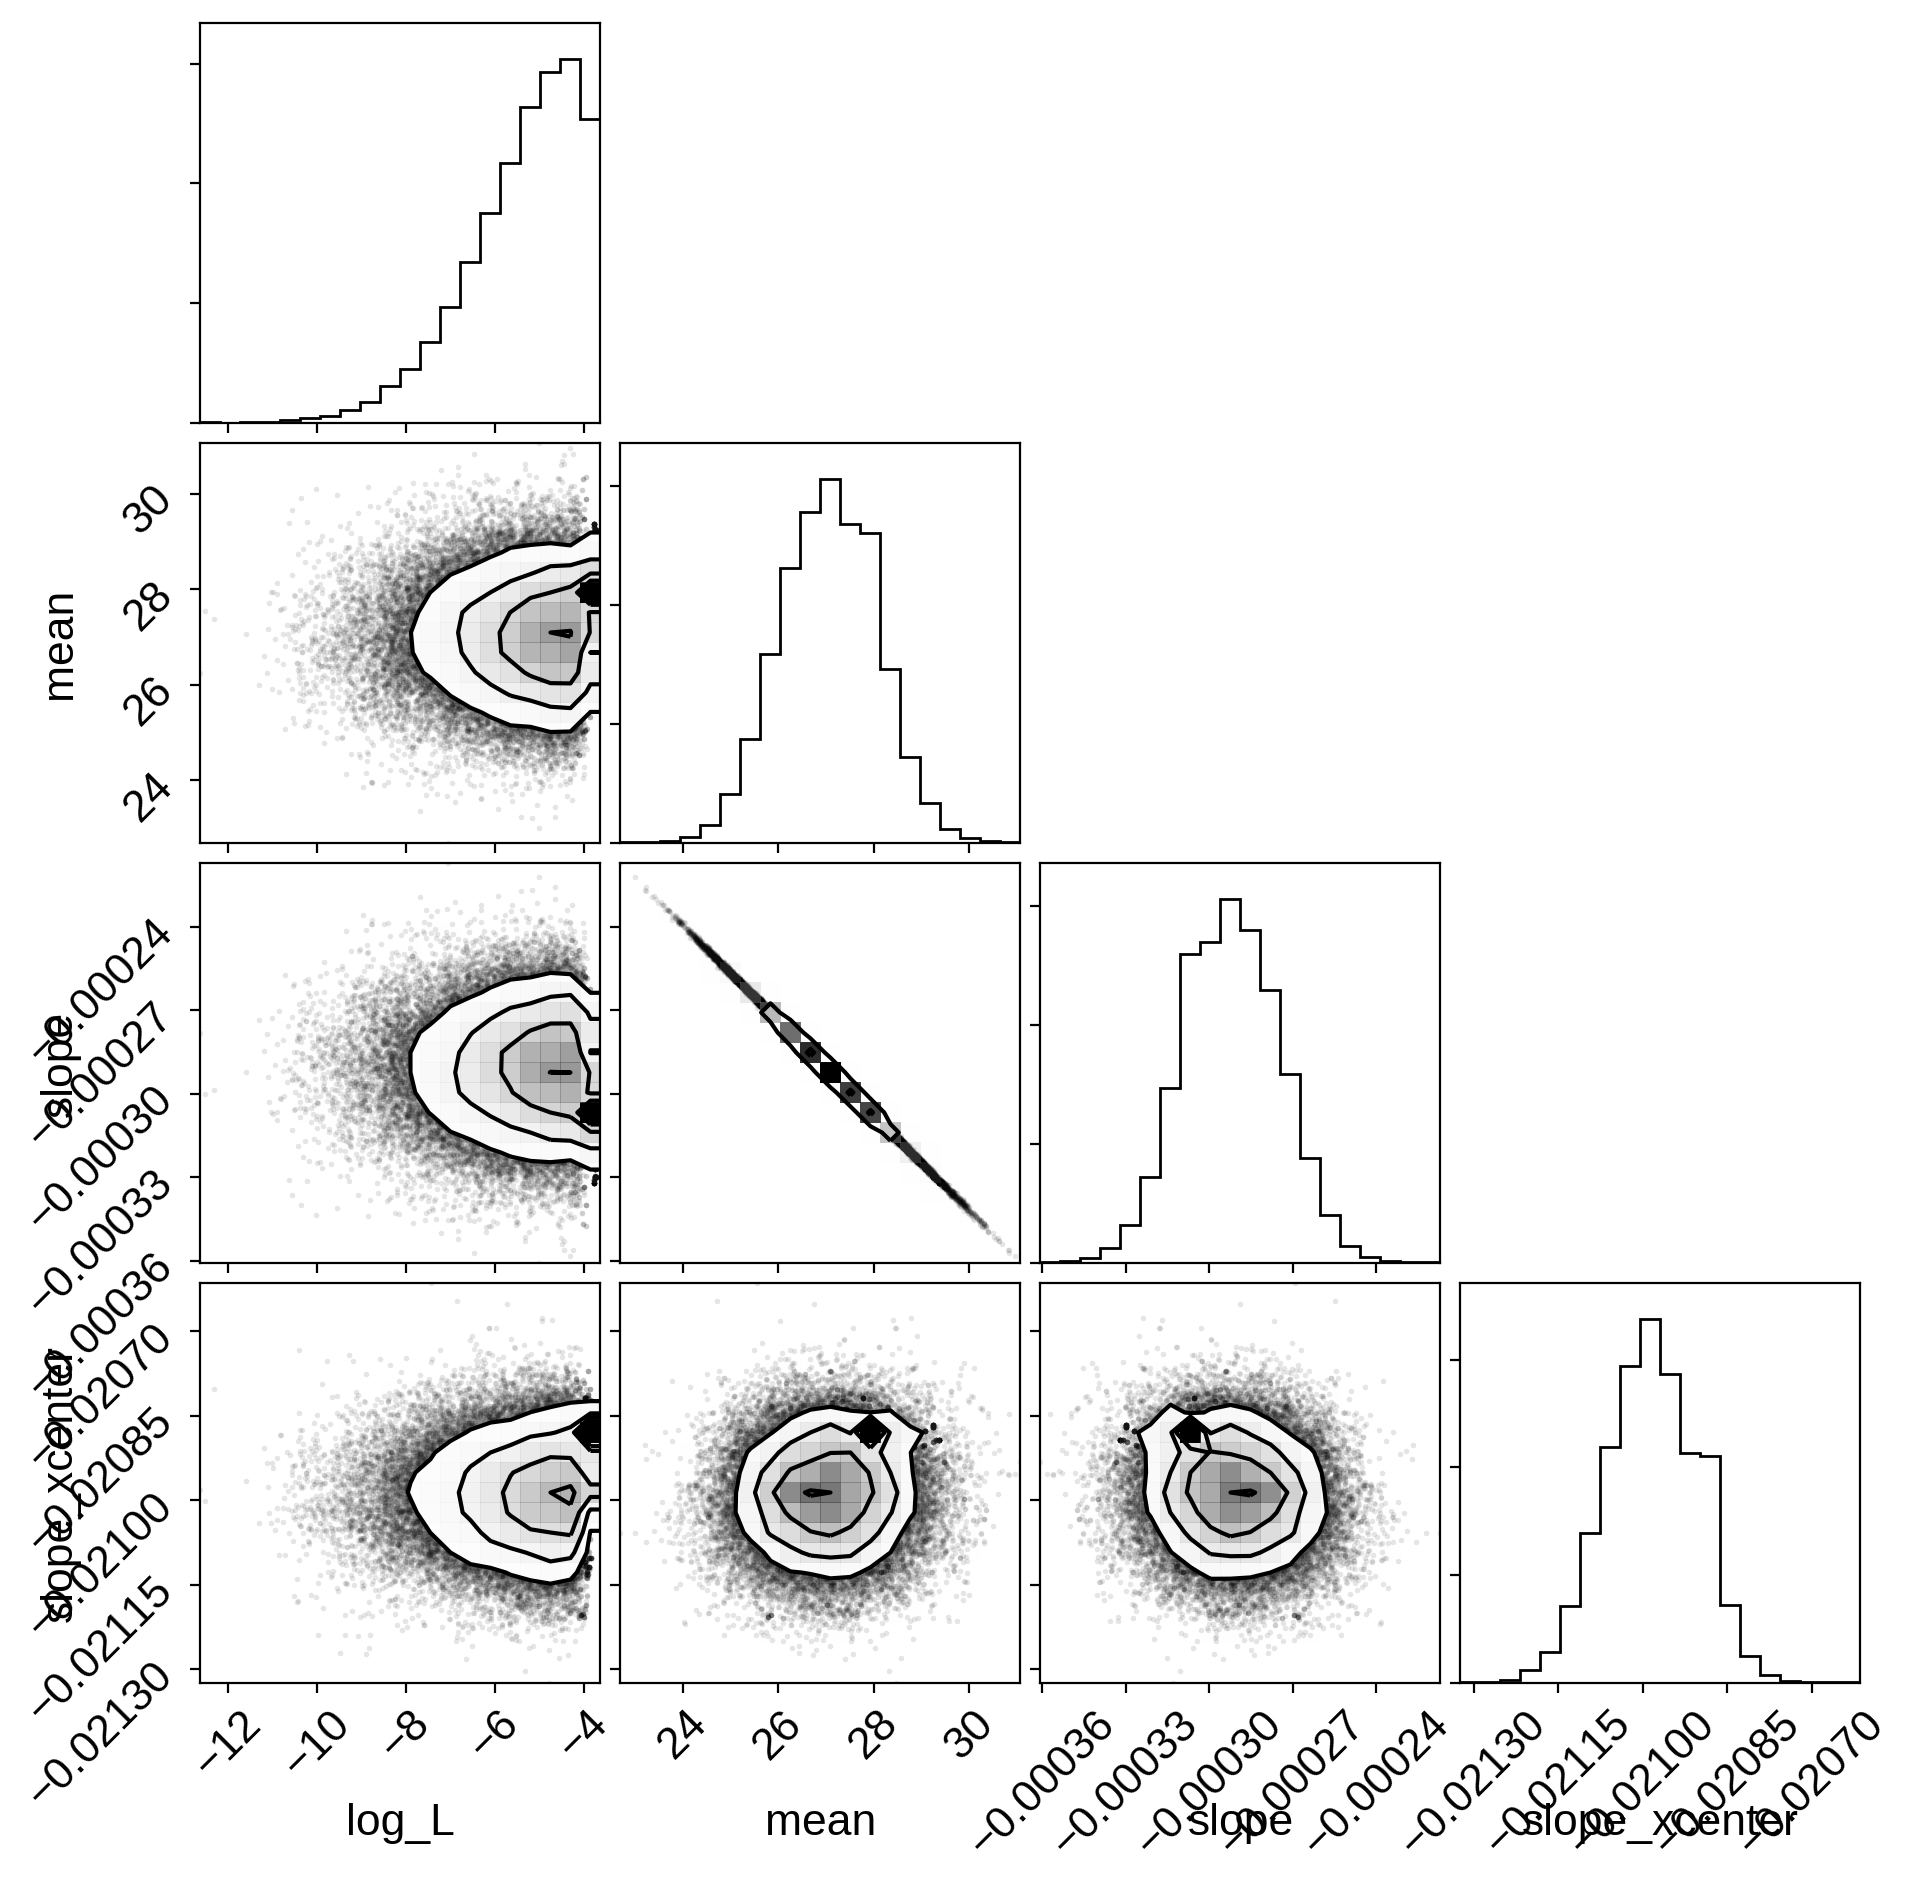

In [242]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(np.array(samples), truths=[-3, 10, 0., 0.], labels=varnames);

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
varnames = ["edepth", "mean", "slope", "slope_xcenter"]

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")